In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import logging
logging.basicConfig(level=logging.INFO, format='')
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import seaborn as sns
import rdkit
from sklearn.impute import SimpleImputer
from scipy.stats import kurtosis, skew
from rdkit import Chem, RDLogger
from rdkit.Chem import Draw
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import PandasTools
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.ML.Descriptors import MoleculeDescriptors
import requests
import torch
import pubchempy as pcp
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
from fast_molvae.sample import load_model
model = load_model('../data/vocab.txt', '../fast_molvae/vae_model/model.epoch-19')
torch.cuda.is_available()
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import random
import joblib
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['font.sans-serif'] = ["Arial"]
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Enabling RDKit 2020.09.1 jupyter extensions
C:\ProgramData\Anaconda3\envs\chemvae2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\ProgramData\Anaconda3\envs\chemvae2\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [2]:
#Plt True vs Pred
def prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat):
    from sklearn import metrics
    fontsize = 16
    lims = (13, 25)
    plt.figure(figsize=(6,5.5))
    plt.style.use('default')
    plt.rc('xtick', labelsize=fontsize)
    plt.rc('ytick', labelsize=fontsize)
    plt.rcParams['font.family']="Arial"
    a = plt.scatter(y_train, y_train_hat, s=20,lw=1.5,c='lightseagreen')
    plt.plot(lims, lims, 'k--', alpha=0.75, linewidth =1.5,zorder=0)
    plt.xlabel('True PCE[%]', fontsize=fontsize)
    plt.ylabel('Predicted PCE[%]', fontsize=fontsize)
    plt.tick_params(direction='in',length=4, width=1, labelsize = fontsize*.85)
    plt.xlim([13,25]) 
    plt.ylim([13,25])
    plt.title(('Train RMSE: {:.2}'.format(np.sqrt(metrics.mean_squared_error(y_train, y_train_hat))),\
           'Test RMSE: {:.2}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_test_hat)))), fontsize=fontsize)
    b = plt.scatter(y_test, y_test_hat, s=20,lw=1.5,c='sandybrown')
    plt.legend((a,b),('Train','Test'),fontsize=fontsize,handletextpad=0.1,borderpad=0.1)
    plt.rcParams['font.family']="Arial"
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)
    
    plt.tight_layout()
    plt.show()
    
    print ('RMSE Train: %.2f' % (np.sqrt(mse(y_train, y_train_hat))))
    print ('RMSE Test: %.2f' % (np.sqrt(mse(y_test, y_test_hat))))
    print('^'*20)
    print ('MAE Train: %.2f' % (mean_absolute_error(y_train, y_train_hat)))
    print ('MAE Test: %.2f' % (mean_absolute_error(y_test, y_test_hat)))
    print('^'*20)
    print ('R2 Train: %.2f' % (r2_score(y_train, y_train_hat)))
    print ('R2 Test: %.2f' % (r2_score(y_test, y_test_hat)))
    print('^'*20)
    print ('Spearman Train: %.2f' % (spearmanr(y_train, y_train_hat)[0]))
    print ('Spearman Test: %.2f' % (spearmanr(y_test, y_test_hat)[0]))
    print('^'*20)

In [3]:
pd.set_option('display.max_rows',None)
data=pd.read_csv('./molecule_data.csv',encoding='gb18030')
data.head()

,Condition #,smiles,Control_PCE,PCE_difference,target_PCE
0,0,Cn1nnnc1S,19.20,1.30,20.50
1,1,I.Nc1ccccc1,19.20,1.30,20.50
2,2,NCC=Cc1ccccc1,17.37,4.61,21.98
3,3,CSCC[C@H](NC(=O)OCC1c2ccccc2c3ccccc13)C(O)=O,14.17,2.58,16.75
4,4,c1ccncc1,13.34,1.00,14.34


In [4]:
#Generate Scaffold
smi_list=data.iloc[:,1].tolist()
mol_list=[]
for i in range(len(smi_list)):
    smile = smi_list[i]
    mol = Chem.MolFromSmiles(smile)
    mol_list.append(mol)
scaffold_list=[]
for i in range(len(mol_list)):
    scaffold=Chem.MolToSmiles(MurckoScaffold.GetScaffoldForMol(mol_list[i]))
    scaffold_list.append(scaffold)
indices = {}
for index, item in enumerate(scaffold_list):
    if item in indices:
        indices[item].append(index)
    else:
        indices[item] = [index]
print(indices)

{'c1nnn[nH]1': [0], 'c1ccccc1': [1, 2, 7, 8, 9, 14, 15, 16, 22, 24, 32, 33, 39, 40, 42, 59, 62, 63, 65, 67, 68, 75, 80, 82, 84], 'c1ccc2c(c1)Cc1ccccc1-2': [3], 'c1ccncc1': [4, 5, 6, 19, 21, 71, 72], 'c1ccc2c(c1)c1ccccc1n2-c1ccncc1': [10], 'c1ccc(-c2ccnc3c2ccc2c(-c4ccccc4)ccnc23)cc1': [11], 'c1cscn1': [12], '': [13, 17, 20, 23, 28, 41, 44, 46, 48, 51, 52, 54, 55, 56, 57, 58, 60, 61, 76, 77, 78, 79], 'O=S(Cc1ccccn1)c1nc2ccccc2[nH]1': [18], 'O=c1[nH]c(=O)c2[nH]cnc2[nH]1': [25, 26, 38], 'O=P(c1ccccc1)(c1ccccc1)c1ccccc1': [27], 'c1ccc(P(c2ccccc2)c2ccccc2)cc1': [29], 'C1CCCCC1': [30], 'c1ccc2ccccc2c1': [31, 64, 73], 'c1cnc2c(c1)ccc1cccnc12': [34], 'c1ccc(-c2cccs2)cc1': [35, 36, 37], 'O=C1C=CC(=O)N1': [43], 'O=c1ccc2cc3c4c(c2o1)CCCN4CCC3': [45], 'O=C1c2ccc3c4cccc5cccc(c6ccc(c2c36)C(=O)N1c1ccccc1)c54': [47], 'O=c1[nH]sc2ccccc12': [49], 'O=c1cc[nH]c(=O)[nH]1': [50], 'C=c1ccc(=C)cc1': [53], 'c1ncc2ncn([C@H]3CCCO3)c2n1': [66], 'O=C(NCCSCc1ccccc1)OCC1c2ccccc2-c2ccccc21': [69], 'c1csc[nH+]1': [70],

In [5]:
#Input as Z+D
df_smi = data.iloc[:,1:2].values

tree_vecs=[]
mol_vecs=[]
for i in np.arange(len(df_smi)):
    all_vec = []
    all_vec = model.encode_from_smiles(df_smi[i])
    tree_vec, mol_vec = np.hsplit(all_vec, 2)
    tree_, _ = model.rsample(tree_vec, model.T_mean, model.T_var)
    mol_, _ = model.rsample(mol_vec, model.G_mean, model.G_var)
    tree_ = tree_.data.cpu().numpy()
    mol_ = mol_.data.cpu().numpy()
    tree_vecs.append(tree_)
    mol_vecs.append(mol_)
tree_vecs=np.array(tree_vecs).reshape(len(df_smi),28)
mol_vecs=np.array(mol_vecs).reshape(len(df_smi),28)
z_vec=np.hstack((tree_vecs,mol_vecs))

molecule_smi= data.iloc[:,1]
descriptors = ['FractionCSP3', 'BCUT2D_MRLOW', 'fr_quatN', 'PEOE_VSA8', 'fr_Ar_N',
       'MinEStateIndex', 'fr_NH0', 'fr_imidazole', 'fr_bicyclic',
       'fr_para_hydroxylation', 'BCUT2D_MWHI', 'PEOE_VSA2',
       'NumSaturatedHeterocycles', 'BalabanJ', 'SlogP_VSA11',
       'NumAliphaticHeterocycles', 'PEOE_VSA5', 'MaxAbsEStateIndex',
       'NumAromaticHeterocycles', 'MaxAbsPartialCharge', 'VSA_EState3',
       'VSA_EState6', 'VSA_EState2', 'HallKierAlpha', 'PEOE_VSA9',
       'fr_aniline', 'fr_pyridine', 'VSA_EState4', 'PEOE_VSA1', 'Chi4v',
       'fr_C_O', 'EState_VSA4', 'SlogP_VSA3', 'MolLogP', 'fr_Nhpyrrole',
       'Chi1v', 'fr_NH1', 'EState_VSA3', 'PEOE_VSA7', 'fr_ether', 'SMR_VSA10',
       'SlogP_VSA8', 'SMR_VSA1', 'HeavyAtomMolWt']
molecule_mols = [Chem.MolFromSmiles(smi) for smi in molecule_smi]
desc_calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors)
result = [desc_calc.CalcDescriptors(mol) for mol in molecule_mols]
desc_df = pd.DataFrame(result)
desc_df.columns = descriptors
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', verbose=0)
imputer.fit(desc_df)
desc = imputer.transform(desc_df)

zd = np.hstack((z_vec,desc))
print(zd.shape)

(129, 100)


In [6]:
# Group Scaffold
scaffold_groups = [
    ['c1nnn[nH]1', 'c1ccccc1','c1ccncc1','c1cscn1','c1ccsc1','C=c1ccc(=C)cc1','c1ccsc1','c1csc[nH+]1',
    'c1ncncn1','C1=NCCN1','c1c[nH]cn1','c1cc[nH+]cc1','S=c1cccc[nH]1'],
    ['c1ccc2c(c1)Cc1ccccc1-2', 'c1ccc2c(c1)c1ccccc1n2-c1ccncc1', 'c1ccc(-c2ccnc3c2ccc2c(-c4ccccc4)ccnc23)cc1',
     'O=S(Cc1ccccn1)c1nc2ccccc2[nH]1','c1ccc2ccccc2c1','c1cnc2c(c1)ccc1cccnc12','O=c1ccc2cc3c4c(c2o1)CCCN4CCC3',
    'O=C1c2ccc3c4cccc5cccc(c6ccc(c2c36)C(=O)N1c1ccccc1)c54','c1ncc2ncn([C@H]3CCCO3)c2n1','O=C(NCCSCc1ccccc1)OCC1c2ccccc2-c2ccccc21',
    'O=c1ccc2ccccc2o1','c1ccc2c(c1)[nH]c1ccccc12'],
    ['','C1CCCCC1'],
    ['O=c1[nH]c(=O)c2[nH]cnc2[nH]1', 'O=C1C=CC(=O)N1','O=c1[nH]sc2ccccc12','O=c1cc[nH]c(=O)[nH]1','O=c1nc[nH]c2nc[nH]c12','O=c1nccc[nH]1',
     'O=c1ccc2ccccc2[nH]1','O=C1/C(=C2/Nc3ccccc3C2=O)Nc2ccccc21','O=C(Nc1ccccc1)Nc1ccccc1','O=C1C=CC(=O)N1c1ccccc1','C1=CC2(Cc3ccccc3N2)Oc2ccccc21',
     'O=C1C=CC(=O)N1c1ccc(Cc2ccc(N3C(=O)C=CC3=O)cc2)cc1','O=C(c1ccccc1)c1ccccc1','O=C(/C=C/C=C/c1ccc2c(c1)OCO2)N1CCCCC1','O=c1cccc[nH]1'],
    ['c1ccc(-c2cccs2)cc1', 'c1ccc(-c2ccccn2)nc1','c1cnc2ncccc2c1','c1csc(-c2ccc(-c3cccs3)c3nsnc23)c1','c1ccc2scnc2c1','c1ccc(Cc2ccccc2)cc1',
     'S=c1[nH]c2ccccc2[nH]1','c1ccc(-n2nc3ccccc3n2)cc1','c1ccc2[nH]ccc2c1','O=S1(=O)N=Cc2ccccc21','c1csc(-c2cccs2)c1','c1ccc(-c2ccccc2)cc1',
     'c1ccc2[nH]cnc2c1','O=C1NC(=O)C(c2ccsc2)=C1c1ccsc1'],
    ['O=P(c1ccccc1)(c1ccccc1)c1ccccc1', 'c1ccc(P(c2ccccc2)c2ccccc2)cc1'],
    ['C1COCCN1','O=C1COCCN1','C1C[NH2+]CCN1','O=C1CC(=O)NC(=O)N1','O=C1CCC(=O)N1','C1CCOCC1','c1ccoc1'],
    ['C1C2CC3CC1CC(C2)C3','O=C1C2CC3CC(C2)CC1C3'],
    ['c1ccc(-c2nc(-c3ccccc3)nc(-c3ccccc3)n2)cc1']
]
    
# Create a dictionary to map each molecule to its scaffold group
scaffold_mapping = {}
for idx, scaffolds in enumerate(scaffold_groups):
    for scaffold in scaffolds:
        scaffold_mapping[scaffold] = idx

# Map each molecule to its corresponding scaffold
def map_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        scaffold = Chem.MolToSmiles(MurckoScaffold.GetScaffoldForMol(mol))
        return scaffold_mapping.get(scaffold, -1)
    return -1

data['scaffold_group'] = data['smiles'].apply(map_scaffold)
for idx, group in enumerate(scaffold_groups):
    count = data[data['scaffold_group'] == idx].shape[0]
    print(f"Scaffold Group {idx}: {count} molecules")

Scaffold Group 0: 43 molecules
Scaffold Group 1: 14 molecules
Scaffold Group 2: 23 molecules
Scaffold Group 3: 17 molecules
Scaffold Group 4: 18 molecules
Scaffold Group 5: 2 molecules
Scaffold Group 6: 7 molecules
Scaffold Group 7: 3 molecules
Scaffold Group 8: 2 molecules


Trials:   0%|                                                                                  | 0/200 [00:00<?, ?it/s]

测试集数量: 13


Trials:   0%|▎                                                                         | 1/200 [00:00<01:19,  2.50it/s]

测试集数量: 13


Trials:   1%|▋                                                                         | 2/200 [00:00<01:16,  2.59it/s]

测试集数量: 13


Trials:   2%|█                                                                         | 3/200 [00:01<01:15,  2.59it/s]

测试集数量: 13


Trials:   2%|█▍                                                                        | 4/200 [00:01<01:12,  2.69it/s]

测试集数量: 13


Trials:   2%|█▊                                                                        | 5/200 [00:01<01:13,  2.65it/s]

测试集数量: 13


Trials:   3%|██▏                                                                       | 6/200 [00:02<01:12,  2.67it/s]

测试集数量: 13


Trials:   4%|██▌                                                                       | 7/200 [00:02<01:12,  2.65it/s]

测试集数量: 13


Trials:   4%|██▉                                                                       | 8/200 [00:02<01:10,  2.72it/s]

测试集数量: 13


Trials:   4%|███▎                                                                      | 9/200 [00:03<01:09,  2.74it/s]

测试集数量: 13


Trials:   5%|███▋                                                                     | 10/200 [00:03<01:08,  2.76it/s]

测试集数量: 13


Trials:   6%|████                                                                     | 11/200 [00:04<01:08,  2.77it/s]

测试集数量: 13


Trials:   6%|████▍                                                                    | 12/200 [00:04<01:08,  2.76it/s]

测试集数量: 13


Trials:   6%|████▋                                                                    | 13/200 [00:04<01:07,  2.78it/s]

测试集数量: 13


Trials:   7%|█████                                                                    | 14/200 [00:05<01:07,  2.77it/s]

测试集数量: 13


Trials:   8%|█████▍                                                                   | 15/200 [00:05<01:06,  2.77it/s]

测试集数量: 13


Trials:   8%|█████▊                                                                   | 16/200 [00:05<01:05,  2.82it/s]

测试集数量: 13


Trials:   8%|██████▏                                                                  | 17/200 [00:06<01:06,  2.75it/s]

测试集数量: 13


Trials:   9%|██████▌                                                                  | 18/200 [00:06<01:08,  2.68it/s]

测试集数量: 13


Trials:  10%|██████▉                                                                  | 19/200 [00:07<01:08,  2.65it/s]

测试集数量: 13


Trials:  10%|███████▎                                                                 | 20/200 [00:07<01:07,  2.67it/s]

测试集数量: 13


Trials:  10%|███████▋                                                                 | 21/200 [00:07<01:04,  2.76it/s]

测试集数量: 13


Trials:  11%|████████                                                                 | 22/200 [00:08<01:09,  2.56it/s]

测试集数量: 13


Trials:  12%|████████▍                                                                | 23/200 [00:08<01:11,  2.46it/s]

测试集数量: 13


Trials:  12%|████████▊                                                                | 24/200 [00:08<01:09,  2.55it/s]

测试集数量: 13


Trials:  12%|█████████▏                                                               | 25/200 [00:09<01:12,  2.40it/s]

测试集数量: 13


Trials:  13%|█████████▍                                                               | 26/200 [00:09<01:16,  2.26it/s]

测试集数量: 13


Trials:  14%|█████████▊                                                               | 27/200 [00:10<01:22,  2.09it/s]

测试集数量: 13


Trials:  14%|██████████▏                                                              | 28/200 [00:11<01:25,  2.02it/s]

测试集数量: 13


Trials:  14%|██████████▌                                                              | 29/200 [00:11<01:25,  1.99it/s]

测试集数量: 13


Trials:  15%|██████████▉                                                              | 30/200 [00:12<01:24,  2.02it/s]

测试集数量: 13


Trials:  16%|███████████▎                                                             | 31/200 [00:12<01:16,  2.21it/s]

测试集数量: 13


Trials:  16%|███████████▋                                                             | 32/200 [00:12<01:12,  2.33it/s]

测试集数量: 13


Trials:  16%|████████████                                                             | 33/200 [00:13<01:10,  2.37it/s]

测试集数量: 13


Trials:  17%|████████████▍                                                            | 34/200 [00:13<01:05,  2.52it/s]

测试集数量: 13


Trials:  18%|████████████▊                                                            | 35/200 [00:13<01:03,  2.60it/s]

测试集数量: 13


Trials:  18%|█████████████▏                                                           | 36/200 [00:14<01:03,  2.58it/s]

测试集数量: 13


Trials:  18%|█████████████▌                                                           | 37/200 [00:14<01:01,  2.66it/s]

测试集数量: 13


Trials:  19%|█████████████▊                                                           | 38/200 [00:14<00:58,  2.76it/s]

测试集数量: 13


Trials:  20%|██████████████▏                                                          | 39/200 [00:15<00:56,  2.84it/s]

测试集数量: 13


Trials:  20%|██████████████▌                                                          | 40/200 [00:15<00:57,  2.78it/s]

测试集数量: 13


Trials:  20%|██████████████▉                                                          | 41/200 [00:16<00:57,  2.77it/s]

测试集数量: 13


Trials:  21%|███████████████▎                                                         | 42/200 [00:16<00:55,  2.83it/s]

测试集数量: 13


Trials:  22%|███████████████▋                                                         | 43/200 [00:16<00:57,  2.71it/s]

测试集数量: 13


Trials:  22%|████████████████                                                         | 44/200 [00:17<01:04,  2.40it/s]

测试集数量: 13


Trials:  22%|████████████████▍                                                        | 45/200 [00:17<01:06,  2.32it/s]

测试集数量: 13


Trials:  23%|████████████████▊                                                        | 46/200 [00:18<01:17,  1.98it/s]

测试集数量: 13


Trials:  24%|█████████████████▏                                                       | 47/200 [00:19<01:22,  1.86it/s]

测试集数量: 13


Trials:  24%|█████████████████▌                                                       | 48/200 [00:19<01:23,  1.83it/s]

测试集数量: 13


Trials:  24%|█████████████████▉                                                       | 49/200 [00:19<01:13,  2.06it/s]

测试集数量: 13


Trials:  25%|██████████████████▎                                                      | 50/200 [00:20<01:09,  2.17it/s]

测试集数量: 13


Trials:  26%|██████████████████▌                                                      | 51/200 [00:20<01:02,  2.38it/s]

测试集数量: 13


Trials:  26%|██████████████████▉                                                      | 52/200 [00:21<01:03,  2.31it/s]

测试集数量: 13


Trials:  26%|███████████████████▎                                                     | 53/200 [00:21<01:06,  2.21it/s]

测试集数量: 13


Trials:  27%|███████████████████▋                                                     | 54/200 [00:22<01:03,  2.32it/s]

测试集数量: 13


Trials:  28%|████████████████████                                                     | 55/200 [00:22<00:59,  2.43it/s]

测试集数量: 13


Trials:  28%|████████████████████▍                                                    | 56/200 [00:22<00:58,  2.48it/s]

测试集数量: 13


Trials:  28%|████████████████████▊                                                    | 57/200 [00:23<00:56,  2.54it/s]

测试集数量: 13


Trials:  29%|█████████████████████▏                                                   | 58/200 [00:23<00:55,  2.58it/s]

测试集数量: 13


Trials:  30%|█████████████████████▌                                                   | 59/200 [00:23<00:54,  2.61it/s]

测试集数量: 13


Trials:  30%|█████████████████████▉                                                   | 60/200 [00:24<00:52,  2.68it/s]

测试集数量: 13


Trials:  30%|██████████████████████▎                                                  | 61/200 [00:24<00:54,  2.55it/s]

测试集数量: 13


Trials:  31%|██████████████████████▋                                                  | 62/200 [00:25<00:55,  2.48it/s]

测试集数量: 13


Trials:  32%|██████████████████████▉                                                  | 63/200 [00:25<00:56,  2.43it/s]

测试集数量: 13


Trials:  32%|███████████████████████▎                                                 | 64/200 [00:25<00:56,  2.42it/s]

测试集数量: 13


Trials:  32%|███████████████████████▋                                                 | 65/200 [00:26<00:54,  2.46it/s]

测试集数量: 13


Trials:  33%|████████████████████████                                                 | 66/200 [00:26<00:54,  2.45it/s]

测试集数量: 13


Trials:  34%|████████████████████████▍                                                | 67/200 [00:27<00:53,  2.49it/s]

测试集数量: 13


Trials:  34%|████████████████████████▊                                                | 68/200 [00:27<00:52,  2.52it/s]

测试集数量: 13


Trials:  34%|█████████████████████████▏                                               | 69/200 [00:27<00:50,  2.57it/s]

测试集数量: 13


Trials:  35%|█████████████████████████▌                                               | 70/200 [00:28<00:49,  2.65it/s]

测试集数量: 13


Trials:  36%|█████████████████████████▉                                               | 71/200 [00:28<00:49,  2.60it/s]

测试集数量: 13


Trials:  36%|██████████████████████████▎                                              | 72/200 [00:29<00:48,  2.64it/s]

测试集数量: 13


Trials:  36%|██████████████████████████▋                                              | 73/200 [00:29<00:48,  2.63it/s]

测试集数量: 13


Trials:  37%|███████████████████████████                                              | 74/200 [00:29<00:48,  2.60it/s]

测试集数量: 13


Trials:  38%|███████████████████████████▍                                             | 75/200 [00:30<00:50,  2.50it/s]

测试集数量: 13


Trials:  38%|███████████████████████████▋                                             | 76/200 [00:30<00:49,  2.53it/s]

测试集数量: 13


Trials:  38%|████████████████████████████                                             | 77/200 [00:31<00:49,  2.49it/s]

测试集数量: 13


Trials:  39%|████████████████████████████▍                                            | 78/200 [00:31<00:48,  2.49it/s]

测试集数量: 13


Trials:  40%|████████████████████████████▊                                            | 79/200 [00:31<00:47,  2.53it/s]

测试集数量: 13


Trials:  40%|█████████████████████████████▏                                           | 80/200 [00:32<00:46,  2.59it/s]

测试集数量: 13


Trials:  40%|█████████████████████████████▌                                           | 81/200 [00:32<00:49,  2.41it/s]

测试集数量: 13


Trials:  41%|█████████████████████████████▉                                           | 82/200 [00:33<00:46,  2.51it/s]

测试集数量: 13


Trials:  42%|██████████████████████████████▎                                          | 83/200 [00:33<00:48,  2.39it/s]

测试集数量: 13


Trials:  42%|██████████████████████████████▋                                          | 84/200 [00:33<00:46,  2.48it/s]

测试集数量: 13


Trials:  42%|███████████████████████████████                                          | 85/200 [00:34<00:44,  2.57it/s]

测试集数量: 13


Trials:  43%|███████████████████████████████▍                                         | 86/200 [00:34<00:44,  2.59it/s]

测试集数量: 13


Trials:  44%|███████████████████████████████▊                                         | 87/200 [00:35<00:44,  2.54it/s]

测试集数量: 13


Trials:  44%|████████████████████████████████                                         | 88/200 [00:35<00:43,  2.59it/s]

测试集数量: 13


Trials:  44%|████████████████████████████████▍                                        | 89/200 [00:35<00:42,  2.63it/s]

测试集数量: 13


Trials:  45%|████████████████████████████████▊                                        | 90/200 [00:36<00:42,  2.58it/s]

测试集数量: 13


Trials:  46%|█████████████████████████████████▏                                       | 91/200 [00:36<00:43,  2.50it/s]

测试集数量: 13


Trials:  46%|█████████████████████████████████▌                                       | 92/200 [00:36<00:43,  2.50it/s]

测试集数量: 13


Trials:  46%|█████████████████████████████████▉                                       | 93/200 [00:37<00:42,  2.53it/s]

测试集数量: 13


Trials:  47%|██████████████████████████████████▎                                      | 94/200 [00:37<00:41,  2.57it/s]

测试集数量: 13


Trials:  48%|██████████████████████████████████▋                                      | 95/200 [00:38<00:40,  2.62it/s]

测试集数量: 13


Trials:  48%|███████████████████████████████████                                      | 96/200 [00:38<00:39,  2.60it/s]

测试集数量: 13


Trials:  48%|███████████████████████████████████▍                                     | 97/200 [00:38<00:40,  2.56it/s]

测试集数量: 13


Trials:  49%|███████████████████████████████████▊                                     | 98/200 [00:39<00:40,  2.55it/s]

测试集数量: 13


Trials:  50%|████████████████████████████████████▏                                    | 99/200 [00:39<00:39,  2.58it/s]

测试集数量: 13


Trials:  50%|████████████████████████████████████                                    | 100/200 [00:40<00:37,  2.67it/s]

测试集数量: 13


Trials:  50%|████████████████████████████████████▎                                   | 101/200 [00:40<00:36,  2.74it/s]

测试集数量: 13


Trials:  51%|████████████████████████████████████▋                                   | 102/200 [00:40<00:35,  2.76it/s]

测试集数量: 13


Trials:  52%|█████████████████████████████████████                                   | 103/200 [00:41<00:36,  2.65it/s]

测试集数量: 13


Trials:  52%|█████████████████████████████████████▍                                  | 104/200 [00:41<00:36,  2.66it/s]

测试集数量: 13


Trials:  52%|█████████████████████████████████████▊                                  | 105/200 [00:41<00:35,  2.66it/s]

测试集数量: 13


Trials:  53%|██████████████████████████████████████▏                                 | 106/200 [00:42<00:35,  2.66it/s]

测试集数量: 13


Trials:  54%|██████████████████████████████████████▌                                 | 107/200 [00:42<00:34,  2.73it/s]

测试集数量: 13


Trials:  54%|██████████████████████████████████████▉                                 | 108/200 [00:42<00:34,  2.70it/s]

测试集数量: 13


Trials:  55%|███████████████████████████████████████▏                                | 109/200 [00:43<00:33,  2.68it/s]

测试集数量: 13


Trials:  55%|███████████████████████████████████████▌                                | 110/200 [00:43<00:32,  2.76it/s]

测试集数量: 13


Trials:  56%|███████████████████████████████████████▉                                | 111/200 [00:44<00:32,  2.74it/s]

测试集数量: 13


Trials:  56%|████████████████████████████████████████▎                               | 112/200 [00:44<00:32,  2.74it/s]

测试集数量: 13


Trials:  56%|████████████████████████████████████████▋                               | 113/200 [00:44<00:30,  2.81it/s]

测试集数量: 13


Trials:  57%|█████████████████████████████████████████                               | 114/200 [00:45<00:31,  2.75it/s]

测试集数量: 13


Trials:  57%|█████████████████████████████████████████▍                              | 115/200 [00:45<00:31,  2.72it/s]

测试集数量: 13


Trials:  58%|█████████████████████████████████████████▊                              | 116/200 [00:45<00:31,  2.71it/s]

测试集数量: 13


Trials:  58%|██████████████████████████████████████████                              | 117/200 [00:46<00:30,  2.71it/s]

测试集数量: 13


Trials:  59%|██████████████████████████████████████████▍                             | 118/200 [00:46<00:30,  2.66it/s]

测试集数量: 13


Trials:  60%|██████████████████████████████████████████▊                             | 119/200 [00:47<00:31,  2.58it/s]

测试集数量: 13


Trials:  60%|███████████████████████████████████████████▏                            | 120/200 [00:47<00:31,  2.54it/s]

测试集数量: 13


Trials:  60%|███████████████████████████████████████████▌                            | 121/200 [00:47<00:31,  2.50it/s]

测试集数量: 13


Trials:  61%|███████████████████████████████████████████▉                            | 122/200 [00:48<00:30,  2.53it/s]

测试集数量: 13


Trials:  62%|████████████████████████████████████████████▎                           | 123/200 [00:48<00:30,  2.55it/s]

测试集数量: 13


Trials:  62%|████████████████████████████████████████████▋                           | 124/200 [00:49<00:29,  2.58it/s]

测试集数量: 13


Trials:  62%|█████████████████████████████████████████████                           | 125/200 [00:49<00:28,  2.64it/s]

测试集数量: 13


Trials:  63%|█████████████████████████████████████████████▎                          | 126/200 [00:49<00:29,  2.50it/s]

测试集数量: 13


Trials:  64%|█████████████████████████████████████████████▋                          | 127/200 [00:50<00:28,  2.53it/s]

测试集数量: 13


Trials:  64%|██████████████████████████████████████████████                          | 128/200 [00:50<00:28,  2.50it/s]

测试集数量: 13


Trials:  64%|██████████████████████████████████████████████▍                         | 129/200 [00:51<00:28,  2.46it/s]

测试集数量: 13


Trials:  65%|██████████████████████████████████████████████▊                         | 130/200 [00:51<00:31,  2.19it/s]

测试集数量: 13


Trials:  66%|███████████████████████████████████████████████▏                        | 131/200 [00:52<00:32,  2.11it/s]

测试集数量: 13


Trials:  66%|███████████████████████████████████████████████▌                        | 132/200 [00:52<00:33,  2.03it/s]

测试集数量: 13


Trials:  66%|███████████████████████████████████████████████▉                        | 133/200 [00:53<00:31,  2.13it/s]

测试集数量: 13


Trials:  67%|████████████████████████████████████████████████▏                       | 134/200 [00:53<00:28,  2.29it/s]

测试集数量: 13


Trials:  68%|████████████████████████████████████████████████▌                       | 135/200 [00:53<00:26,  2.46it/s]

测试集数量: 13


Trials:  68%|████████████████████████████████████████████████▉                       | 136/200 [00:54<00:25,  2.50it/s]

测试集数量: 13


Trials:  68%|█████████████████████████████████████████████████▎                      | 137/200 [00:54<00:25,  2.47it/s]

测试集数量: 13


Trials:  69%|█████████████████████████████████████████████████▋                      | 138/200 [00:54<00:24,  2.56it/s]

测试集数量: 13


Trials:  70%|██████████████████████████████████████████████████                      | 139/200 [00:55<00:23,  2.60it/s]

测试集数量: 13


Trials:  70%|██████████████████████████████████████████████████▍                     | 140/200 [00:55<00:22,  2.63it/s]

测试集数量: 13


Trials:  70%|██████████████████████████████████████████████████▊                     | 141/200 [00:56<00:21,  2.74it/s]

测试集数量: 13


Trials:  71%|███████████████████████████████████████████████████                     | 142/200 [00:56<00:21,  2.75it/s]

测试集数量: 13


Trials:  72%|███████████████████████████████████████████████████▍                    | 143/200 [00:56<00:20,  2.73it/s]

测试集数量: 13


Trials:  72%|███████████████████████████████████████████████████▊                    | 144/200 [00:57<00:19,  2.81it/s]

测试集数量: 13


Trials:  72%|████████████████████████████████████████████████████▏                   | 145/200 [00:57<00:20,  2.73it/s]

测试集数量: 13


Trials:  73%|████████████████████████████████████████████████████▌                   | 146/200 [00:57<00:19,  2.71it/s]

测试集数量: 13


Trials:  74%|████████████████████████████████████████████████████▉                   | 147/200 [00:58<00:19,  2.71it/s]

测试集数量: 13


Trials:  74%|█████████████████████████████████████████████████████▎                  | 148/200 [00:58<00:19,  2.69it/s]

测试集数量: 13


Trials:  74%|█████████████████████████████████████████████████████▋                  | 149/200 [00:58<00:18,  2.76it/s]

测试集数量: 13


Trials:  75%|██████████████████████████████████████████████████████                  | 150/200 [00:59<00:17,  2.82it/s]

测试集数量: 13


Trials:  76%|██████████████████████████████████████████████████████▎                 | 151/200 [00:59<00:18,  2.72it/s]

测试集数量: 13


Trials:  76%|██████████████████████████████████████████████████████▋                 | 152/200 [01:00<00:20,  2.38it/s]

测试集数量: 13


Trials:  76%|███████████████████████████████████████████████████████                 | 153/200 [01:00<00:21,  2.23it/s]

测试集数量: 13


Trials:  77%|███████████████████████████████████████████████████████▍                | 154/200 [01:01<00:21,  2.12it/s]

测试集数量: 13


Trials:  78%|███████████████████████████████████████████████████████▊                | 155/200 [01:01<00:21,  2.10it/s]

测试集数量: 13


Trials:  78%|████████████████████████████████████████████████████████▏               | 156/200 [01:02<00:21,  2.09it/s]

测试集数量: 13


Trials:  78%|████████████████████████████████████████████████████████▌               | 157/200 [01:02<00:19,  2.18it/s]

测试集数量: 13


Trials:  79%|████████████████████████████████████████████████████████▉               | 158/200 [01:03<00:18,  2.29it/s]

测试集数量: 13


Trials:  80%|█████████████████████████████████████████████████████████▏              | 159/200 [01:03<00:17,  2.34it/s]

测试集数量: 13


Trials:  80%|█████████████████████████████████████████████████████████▌              | 160/200 [01:03<00:16,  2.41it/s]

测试集数量: 13


Trials:  80%|█████████████████████████████████████████████████████████▉              | 161/200 [01:04<00:15,  2.46it/s]

测试集数量: 13


Trials:  81%|██████████████████████████████████████████████████████████▎             | 162/200 [01:04<00:15,  2.52it/s]

测试集数量: 13


Trials:  82%|██████████████████████████████████████████████████████████▋             | 163/200 [01:04<00:14,  2.51it/s]

测试集数量: 13


Trials:  82%|███████████████████████████████████████████████████████████             | 164/200 [01:05<00:13,  2.57it/s]

测试集数量: 13


Trials:  82%|███████████████████████████████████████████████████████████▍            | 165/200 [01:05<00:13,  2.55it/s]

测试集数量: 13


Trials:  83%|███████████████████████████████████████████████████████████▊            | 166/200 [01:06<00:13,  2.54it/s]

测试集数量: 13


Trials:  84%|████████████████████████████████████████████████████████████            | 167/200 [01:06<00:13,  2.52it/s]

测试集数量: 13


Trials:  84%|████████████████████████████████████████████████████████████▍           | 168/200 [01:06<00:12,  2.56it/s]

测试集数量: 13


Trials:  84%|████████████████████████████████████████████████████████████▊           | 169/200 [01:07<00:11,  2.62it/s]

测试集数量: 13


Trials:  85%|█████████████████████████████████████████████████████████████▏          | 170/200 [01:07<00:11,  2.60it/s]

测试集数量: 13


Trials:  86%|█████████████████████████████████████████████████████████████▌          | 171/200 [01:08<00:11,  2.61it/s]

测试集数量: 13


Trials:  86%|█████████████████████████████████████████████████████████████▉          | 172/200 [01:08<00:10,  2.61it/s]

测试集数量: 13


Trials:  86%|██████████████████████████████████████████████████████████████▎         | 173/200 [01:08<00:10,  2.64it/s]

测试集数量: 13


Trials:  87%|██████████████████████████████████████████████████████████████▋         | 174/200 [01:09<00:10,  2.56it/s]

测试集数量: 13


Trials:  88%|███████████████████████████████████████████████████████████████         | 175/200 [01:09<00:09,  2.64it/s]

测试集数量: 13


Trials:  88%|███████████████████████████████████████████████████████████████▎        | 176/200 [01:09<00:09,  2.63it/s]

测试集数量: 13


Trials:  88%|███████████████████████████████████████████████████████████████▋        | 177/200 [01:10<00:08,  2.58it/s]

测试集数量: 13


Trials:  89%|████████████████████████████████████████████████████████████████        | 178/200 [01:10<00:08,  2.58it/s]

测试集数量: 13


Trials:  90%|████████████████████████████████████████████████████████████████▍       | 179/200 [01:11<00:08,  2.57it/s]

测试集数量: 13


Trials:  90%|████████████████████████████████████████████████████████████████▊       | 180/200 [01:11<00:07,  2.62it/s]

测试集数量: 13


Trials:  90%|█████████████████████████████████████████████████████████████████▏      | 181/200 [01:11<00:07,  2.68it/s]

测试集数量: 13


Trials:  91%|█████████████████████████████████████████████████████████████████▌      | 182/200 [01:12<00:06,  2.66it/s]

测试集数量: 13


Trials:  92%|█████████████████████████████████████████████████████████████████▉      | 183/200 [01:12<00:06,  2.64it/s]

测试集数量: 13


Trials:  92%|██████████████████████████████████████████████████████████████████▏     | 184/200 [01:13<00:06,  2.65it/s]

测试集数量: 13


Trials:  92%|██████████████████████████████████████████████████████████████████▌     | 185/200 [01:13<00:05,  2.65it/s]

测试集数量: 13


Trials:  93%|██████████████████████████████████████████████████████████████████▉     | 186/200 [01:13<00:05,  2.51it/s]

测试集数量: 13


Trials:  94%|███████████████████████████████████████████████████████████████████▎    | 187/200 [01:14<00:05,  2.30it/s]

测试集数量: 13


Trials:  94%|███████████████████████████████████████████████████████████████████▋    | 188/200 [01:14<00:04,  2.42it/s]

测试集数量: 13


Trials:  94%|████████████████████████████████████████████████████████████████████    | 189/200 [01:15<00:04,  2.47it/s]

测试集数量: 13


Trials:  95%|████████████████████████████████████████████████████████████████████▍   | 190/200 [01:15<00:04,  2.30it/s]

测试集数量: 13


Trials:  96%|████████████████████████████████████████████████████████████████████▊   | 191/200 [01:15<00:03,  2.42it/s]

测试集数量: 13


Trials:  96%|█████████████████████████████████████████████████████████████████████   | 192/200 [01:16<00:03,  2.45it/s]

测试集数量: 13


Trials:  96%|█████████████████████████████████████████████████████████████████████▍  | 193/200 [01:16<00:02,  2.43it/s]

测试集数量: 13


Trials:  97%|█████████████████████████████████████████████████████████████████████▊  | 194/200 [01:17<00:02,  2.25it/s]

测试集数量: 13


Trials:  98%|██████████████████████████████████████████████████████████████████████▏ | 195/200 [01:17<00:02,  2.22it/s]

测试集数量: 13


Trials:  98%|██████████████████████████████████████████████████████████████████████▌ | 196/200 [01:18<00:01,  2.17it/s]

测试集数量: 13


Trials:  98%|██████████████████████████████████████████████████████████████████████▉ | 197/200 [01:18<00:01,  2.00it/s]

测试集数量: 13


Trials:  99%|███████████████████████████████████████████████████████████████████████▎| 198/200 [01:19<00:00,  2.14it/s]

测试集数量: 13


Trials: 100%|███████████████████████████████████████████████████████████████████████▋| 199/200 [01:19<00:00,  2.19it/s]

测试集数量: 13


Trials: 100%|████████████████████████████████████████████████████████████████████████| 200/200 [01:20<00:00,  2.50it/s]


Test group sizes for each trial:
Iteration 1: [2, 1, 2, 2, 2, 1, 1, 1, 1]
Iteration 2: [2, 2, 1, 1, 2, 1, 2, 1, 1]
Iteration 3: [2, 1, 2, 1, 2, 1, 2, 1, 1]
Iteration 4: [1, 2, 2, 1, 2, 1, 2, 1, 1]
Iteration 5: [2, 2, 2, 1, 1, 1, 2, 1, 1]
Iteration 6: [2, 2, 1, 2, 2, 1, 1, 1, 1]
Iteration 7: [2, 1, 2, 2, 2, 1, 1, 1, 1]
Iteration 8: [1, 1, 2, 2, 2, 1, 2, 1, 1]
Iteration 9: [2, 1, 1, 2, 2, 1, 2, 1, 1]
Iteration 10: [2, 2, 2, 1, 1, 1, 2, 1, 1]
Iteration 11: [1, 2, 2, 2, 1, 1, 2, 1, 1]
Iteration 12: [2, 1, 2, 2, 2, 1, 1, 1, 1]
Iteration 13: [2, 2, 1, 1, 2, 1, 2, 1, 1]
Iteration 14: [2, 2, 1, 2, 1, 1, 2, 1, 1]
Iteration 15: [2, 2, 2, 1, 2, 1, 1, 1, 1]
Iteration 16: [1, 1, 2, 2, 2, 1, 2, 1, 1]
Iteration 17: [1, 2, 2, 2, 2, 1, 1, 1, 1]
Iteration 18: [2, 2, 2, 2, 1, 1, 1, 1, 1]
Iteration 19: [2, 2, 2, 2, 1, 1, 1, 1, 1]
Iteration 20: [2, 2, 2, 1, 1, 1, 2, 1, 1]
Iteration 21: [1, 2, 2, 1, 2, 1, 2, 1, 1]
Iteration 22: [2, 1, 2, 2, 2, 1, 1, 1, 1]
Iteration 23: [2, 1, 2, 1, 2, 1, 2, 1, 1]
Iteration 

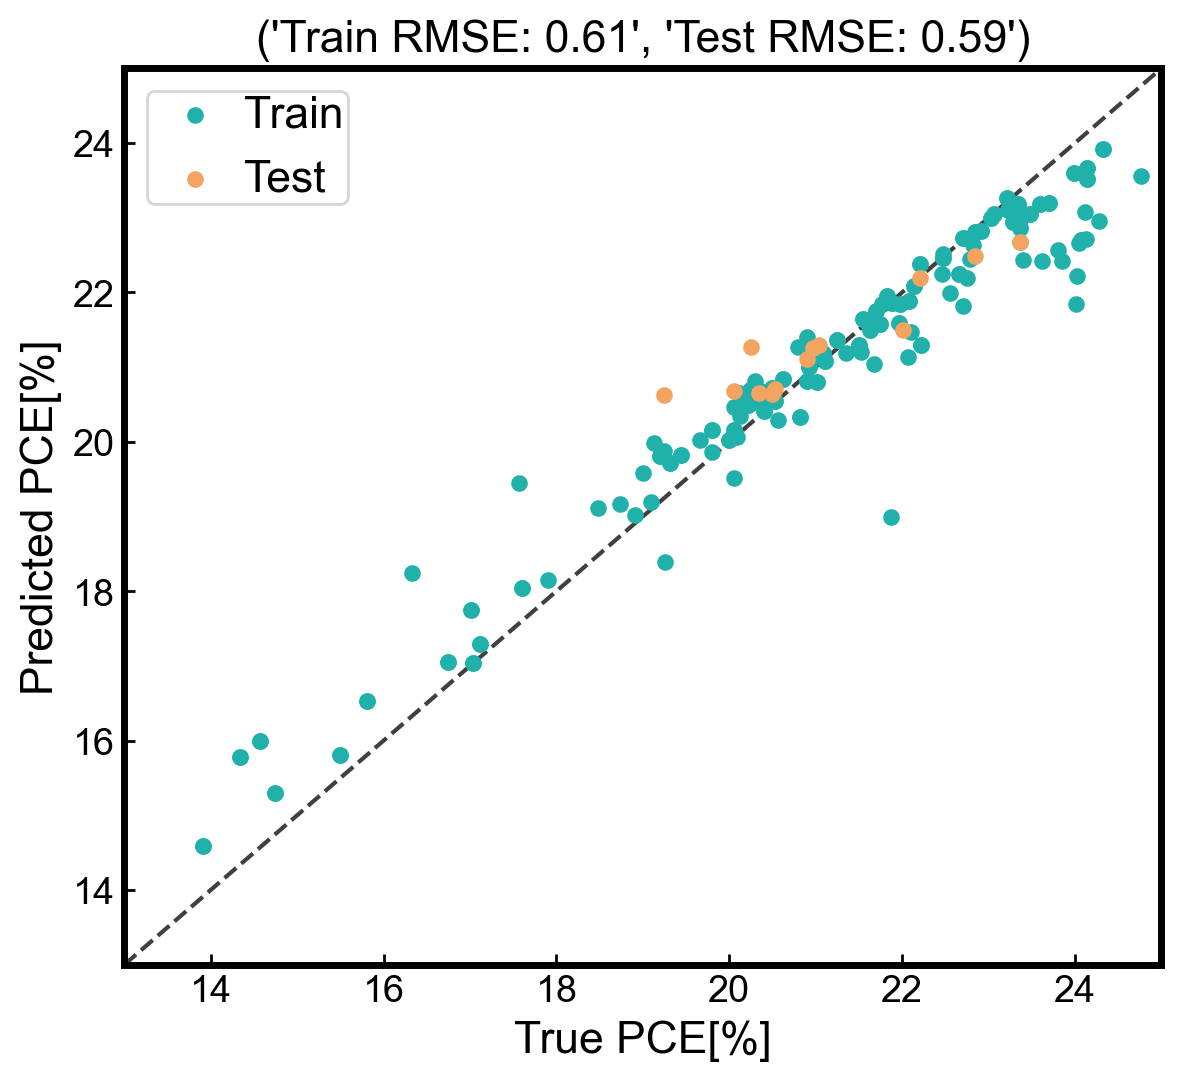

RMSE Train: 0.61
RMSE Test: 0.59
^^^^^^^^^^^^^^^^^^^^
MAE Train: 0.42
MAE Test: 0.46
^^^^^^^^^^^^^^^^^^^^
R2 Train: 0.94
R2 Test: 0.73
^^^^^^^^^^^^^^^^^^^^
Spearman Train: 0.96
Spearman Test: 0.88
^^^^^^^^^^^^^^^^^^^^


['Model_RF_ZD.pkl']

In [15]:
###RF
from sklearn.ensemble import RandomForestRegressor

# Initialize an empty DataFrame to store metrics
metrics_df = pd.DataFrame(columns=['RMSE', 'MAE', 'Spearman', 'R2'])

# Store the indices of the training and testing sets for the best model
best_train_idx = None
best_test_idx = None
best_rmse = float('inf')
rmse_scores = []
mae_scores = []
spearman_scores = []
r2_scores = []

# Store the number of molecules in each scaffold_group for the test set in each round
test_group_sizes = []

# Repeat the testing 200 times
num_trials = 200

for _ in tqdm(range(num_trials), desc="Trials"):
    # Split the dataset into training and testing sets
    train_data = pd.DataFrame(columns=['smiles', 'target_PCE', 'scaffold_group'])
    test_data = pd.DataFrame(columns=['smiles', 'target_PCE', 'scaffold_group'])
    
    # Select one sample from each scaffold_group for the test set
    for group_idx in range(len(scaffold_groups)):
        group_df = data[data['scaffold_group'] == group_idx]
        test_df = group_df.sample(n=1)
        train_df = group_df.drop(test_df.index)

        train_data = pd.concat([train_data, train_df], ignore_index=False)
        test_data = pd.concat([test_data, test_df], ignore_index=False)

    # Ensure the total test set size is 13
    total_test_size = 13
    test_size_per_group = total_test_size - len(scaffold_groups)
    remaining_scaffold_groups = [group_idx for group_idx in range(len(scaffold_groups)) if len(data[data['scaffold_group'] == group_idx]) > 3]

    for _ in range(test_size_per_group):
        # Randomly select a scaffold_group
        random_group_idx = random.choice(remaining_scaffold_groups)
        group_df = data[data['scaffold_group'] == random_group_idx]
        num_samples = len(group_df)
        test_size = min(1, num_samples)  # Ensure at least one molecule is selected for the test set
        test_df = group_df.sample(n=test_size)
        train_df = group_df.drop(test_df.index)

        train_data = pd.concat([train_data, train_df], ignore_index=False)
        test_data = pd.concat([test_data, test_df], ignore_index=False)
        
        test_size_per_group -= test_size
        remaining_scaffold_groups.remove(random_group_idx)
        
        # Exit the loop if the required number of test samples has been reached
        if test_size_per_group <= 0:
            break

    # Record the number of molecules from each scaffold_group in the test set for each round
    test_group_sizes.append(test_data.groupby('scaffold_group').size().tolist())

    X_scaler = MinMaxScaler()
    X_scaler.fit(zd)
    zd = X_scaler.transform(zd)

    X_train = zd[train_data.index]
    y_train = np.transpose([train_data['target_PCE'].values])
    X_test = zd[test_data.index]
    y_test = np.transpose([test_data['target_PCE'].values])
    print("Test set size:", len(y_test))

    # Fit to the training set
    rf_reg = RandomForestRegressor(n_estimators=55, max_depth=10)
    rf_reg.fit(X_train, y_train)

    # Perform predictions on both the training and test sets
    y_train_pred = rf_reg.predict(X_train)
    y_test_pred = rf_reg.predict(X_test)

    # Calculate RMSE, MAE, Spearman correlation, and R2 score for the current test
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae = mean_absolute_error(y_test, y_test_pred)
    spearman_corr, _ = spearmanr(y_test.flatten(), y_test_pred.flatten())
    r2 = r2_score(y_test, y_test_pred)
    
    # Store the metrics for each trial
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    spearman_scores.append(spearman_corr)
    r2_scores.append(r2)

    # Record the metrics in the DataFrame
    metrics_df = metrics_df.append({'RMSE': rmse, 'MAE': mae, 'Spearman': spearman_corr, 'R2': r2}, ignore_index=True)


    # If the current model has a better RMSE, update the best model's predictions and true values
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_predictions = y_test_pred
        best_model_true_values = y_test
        best_train_idx = train_data.index.tolist()
        best_test_idx = test_data.index.tolist()
        
# Calculate mean and standard deviation
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)
mean_spearman = np.mean(spearman_scores)
std_spearman = np.std(spearman_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

# Save the mean and standard deviation to a DataFrame
summary_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'Spearman', 'R2'],
    'Mean': [mean_rmse, mean_mae, mean_spearman, mean_r2],
    'Std': [std_rmse, std_mae, std_spearman, std_r2]})

# Save the metrics to a CSV file
metrics_df.to_csv('metrics_RF_ZD.csv', index=False)
summary_df.to_csv('metrics_summary_RF_ZD.csv', index=False)

# Print the number of molecules in each scaffold_group for every test set
print("Test group sizes for each trial:")
for i, sizes in enumerate(test_group_sizes):
    print(f"Iteration {i+1}: {sizes}")
    
# Print the summary of mean and standard deviation
print(summary_df)

# Plot the predicted vs ground truth values for the best model
prediction_vs_ground_truth_fig(y_train, y_train_pred, best_model_true_values, best_model_predictions)

# Save the indices of the best model's training and testing sets to a CSV file
best_model_indices_df = pd.DataFrame({'train_idx': pd.Series(best_train_idx), 'test_idx': pd.Series(best_test_idx)})
best_model_indices_df.to_csv('Indices_RF_ZD.csv', index=False)

# Save the best model
rf_reg = RandomForestRegressor(n_estimators=55, max_depth=10)
rf_reg.fit(zd[best_train_idx], data['target_PCE'][best_train_idx])
joblib.dump(rf_reg, 'Model_RF_ZD.pkl')

Trials:   0%|▎                                                                         | 1/200 [00:00<00:43,  4.59it/s]

测试集数量: 13


Trials:   1%|▋                                                                         | 2/200 [00:00<00:40,  4.94it/s]

测试集数量: 13


Trials:   2%|█                                                                         | 3/200 [00:00<00:40,  4.85it/s]

测试集数量: 13


Trials:   2%|█▍                                                                        | 4/200 [00:00<00:42,  4.66it/s]

测试集数量: 13


Trials:   2%|█▊                                                                        | 5/200 [00:01<00:41,  4.65it/s]

测试集数量: 13


Trials:   3%|██▏                                                                       | 6/200 [00:01<00:42,  4.59it/s]

测试集数量: 13


Trials:   4%|██▌                                                                       | 7/200 [00:01<00:40,  4.76it/s]

测试集数量: 13
测试集数量: 13


Trials:   4%|███▎                                                                      | 9/200 [00:01<00:41,  4.59it/s]

测试集数量: 13


Trials:   5%|███▋                                                                     | 10/200 [00:02<00:43,  4.42it/s]

测试集数量: 13


Trials:   6%|████                                                                     | 11/200 [00:02<00:40,  4.62it/s]

测试集数量: 13


Trials:   6%|████▍                                                                    | 12/200 [00:02<00:40,  4.63it/s]

测试集数量: 13
测试集数量: 13


Trials:   7%|█████                                                                    | 14/200 [00:02<00:39,  4.71it/s]

测试集数量: 13


Trials:   8%|█████▍                                                                   | 15/200 [00:03<00:38,  4.78it/s]

测试集数量: 13


Trials:   8%|█████▊                                                                   | 16/200 [00:03<00:38,  4.75it/s]

测试集数量: 13


Trials:   8%|██████▏                                                                  | 17/200 [00:03<00:37,  4.86it/s]

测试集数量: 13


Trials:   9%|██████▌                                                                  | 18/200 [00:03<00:41,  4.40it/s]

测试集数量: 13


Trials:  10%|██████▉                                                                  | 19/200 [00:04<00:45,  3.94it/s]

测试集数量: 13


Trials:  10%|███████▎                                                                 | 20/200 [00:04<00:45,  3.96it/s]

测试集数量: 13


Trials:  10%|███████▋                                                                 | 21/200 [00:04<00:43,  4.14it/s]

测试集数量: 13


Trials:  11%|████████                                                                 | 22/200 [00:04<00:47,  3.78it/s]

测试集数量: 13


Trials:  12%|████████▍                                                                | 23/200 [00:05<00:49,  3.61it/s]

测试集数量: 13


Trials:  12%|████████▊                                                                | 24/200 [00:05<00:44,  3.97it/s]

测试集数量: 13


Trials:  12%|█████████▏                                                               | 25/200 [00:05<00:43,  4.05it/s]

测试集数量: 13


Trials:  13%|█████████▍                                                               | 26/200 [00:06<00:46,  3.73it/s]

测试集数量: 13


Trials:  14%|█████████▊                                                               | 27/200 [00:06<00:48,  3.54it/s]

测试集数量: 13


Trials:  14%|██████████▏                                                              | 28/200 [00:06<00:47,  3.59it/s]

测试集数量: 13


Trials:  14%|██████████▌                                                              | 29/200 [00:06<00:45,  3.73it/s]

测试集数量: 13


Trials:  15%|██████████▉                                                              | 30/200 [00:07<00:43,  3.94it/s]

测试集数量: 13


Trials:  16%|███████████▎                                                             | 31/200 [00:07<00:41,  4.11it/s]

测试集数量: 13


Trials:  16%|███████████▋                                                             | 32/200 [00:07<00:41,  4.08it/s]

测试集数量: 13


Trials:  16%|████████████                                                             | 33/200 [00:07<00:40,  4.10it/s]

测试集数量: 13


Trials:  17%|████████████▍                                                            | 34/200 [00:08<00:38,  4.30it/s]

测试集数量: 13


Trials:  18%|████████████▊                                                            | 35/200 [00:08<00:38,  4.27it/s]

测试集数量: 13


Trials:  18%|█████████████▏                                                           | 36/200 [00:08<00:38,  4.28it/s]

测试集数量: 13


Trials:  18%|█████████████▌                                                           | 37/200 [00:08<00:37,  4.29it/s]

测试集数量: 13


Trials:  19%|█████████████▊                                                           | 38/200 [00:08<00:36,  4.38it/s]

测试集数量: 13


Trials:  20%|██████████████▏                                                          | 39/200 [00:09<00:36,  4.44it/s]

测试集数量: 13
测试集数量:

Trials:  20%|██████████████▌                                                          | 40/200 [00:09<00:37,  4.30it/s]

 13


Trials:  20%|██████████████▉                                                          | 41/200 [00:09<00:40,  3.95it/s]

测试集数量: 13


Trials:  21%|███████████████▎                                                         | 42/200 [00:09<00:39,  3.96it/s]

测试集数量: 13
测试集数量: 13


Trials:  22%|████████████████                                                         | 44/200 [00:10<00:46,  3.33it/s]

测试集数量: 13


Trials:  22%|████████████████▍                                                        | 45/200 [00:10<00:46,  3.33it/s]

测试集数量: 13


Trials:  23%|████████████████▊                                                        | 46/200 [00:11<00:44,  3.43it/s]

测试集数量: 13


Trials:  24%|█████████████████▏                                                       | 47/200 [00:11<00:46,  3.29it/s]

测试集数量: 13
测试集数量: 13


Trials:  24%|█████████████████▉                                                       | 49/200 [00:12<00:50,  3.01it/s]

测试集数量: 13


Trials:  25%|██████████████████▎                                                      | 50/200 [00:12<00:49,  3.06it/s]

测试集数量: 13


Trials:  26%|██████████████████▌                                                      | 51/200 [00:12<00:50,  2.93it/s]

测试集数量: 13


Trials:  26%|██████████████████▉                                                      | 52/200 [00:13<00:49,  3.02it/s]

测试集数量: 13


Trials:  26%|███████████████████▎                                                     | 53/200 [00:13<00:43,  3.35it/s]

测试集数量: 13


Trials:  27%|███████████████████▋                                                     | 54/200 [00:13<00:39,  3.66it/s]

测试集数量: 13


Trials:  28%|████████████████████                                                     | 55/200 [00:13<00:39,  3.69it/s]

测试集数量: 13


Trials:  28%|████████████████████▍                                                    | 56/200 [00:14<00:38,  3.78it/s]

测试集数量: 13


Trials:  28%|████████████████████▊                                                    | 57/200 [00:14<00:36,  3.90it/s]

测试集数量: 13


Trials:  29%|█████████████████████▏                                                   | 58/200 [00:14<00:35,  4.04it/s]

测试集数量: 13


Trials:  30%|█████████████████████▌                                                   | 59/200 [00:14<00:33,  4.17it/s]

测试集数量: 13


Trials:  30%|█████████████████████▉                                                   | 60/200 [00:15<00:32,  4.30it/s]

测试集数量: 13


Trials:  30%|██████████████████████▎                                                  | 61/200 [00:15<00:31,  4.39it/s]

测试集数量: 13


Trials:  31%|██████████████████████▋                                                  | 62/200 [00:15<00:30,  4.46it/s]

测试集数量: 13


Trials:  32%|██████████████████████▉                                                  | 63/200 [00:15<00:30,  4.51it/s]

测试集数量: 13


Trials:  32%|███████████████████████▎                                                 | 64/200 [00:16<00:34,  3.99it/s]

测试集数量: 13


Trials:  32%|███████████████████████▋                                                 | 65/200 [00:16<00:37,  3.60it/s]

测试集数量: 13


Trials:  33%|████████████████████████                                                 | 66/200 [00:16<00:35,  3.74it/s]

测试集数量: 13


Trials:  34%|████████████████████████▍                                                | 67/200 [00:17<00:39,  3.36it/s]

测试集数量: 13


Trials:  34%|████████████████████████▊                                                | 68/200 [00:17<00:40,  3.25it/s]

测试集数量: 13


Trials:  34%|█████████████████████████▏                                               | 69/200 [00:17<00:39,  3.33it/s]

测试集数量: 13


Trials:  35%|█████████████████████████▌                                               | 70/200 [00:18<00:40,  3.17it/s]

测试集数量: 13
测试集数量: 13


Trials:  36%|██████████████████████████▎                                              | 72/200 [00:18<00:41,  3.09it/s]

测试集数量: 13


Trials:  36%|██████████████████████████▋                                              | 73/200 [00:18<00:40,  3.13it/s]

测试集数量: 13


Trials:  37%|███████████████████████████                                              | 74/200 [00:19<00:35,  3.57it/s]

测试集数量: 13


Trials:  38%|███████████████████████████▍                                             | 75/200 [00:19<00:33,  3.76it/s]

测试集数量: 13


Trials:  38%|███████████████████████████▋                                             | 76/200 [00:19<00:32,  3.83it/s]

测试集数量: 13


Trials:  38%|████████████████████████████                                             | 77/200 [00:19<00:31,  3.95it/s]

测试集数量: 13


Trials:  39%|████████████████████████████▍                                            | 78/200 [00:20<00:30,  3.97it/s]

测试集数量: 13


Trials:  40%|████████████████████████████▊                                            | 79/200 [00:20<00:29,  4.06it/s]

测试集数量: 13


Trials:  40%|█████████████████████████████▏                                           | 80/200 [00:20<00:28,  4.22it/s]

测试集数量: 13


Trials:  40%|█████████████████████████████▌                                           | 81/200 [00:20<00:26,  4.45it/s]

测试集数量: 13


Trials:  41%|█████████████████████████████▉                                           | 82/200 [00:20<00:26,  4.53it/s]

测试集数量: 13


Trials:  42%|██████████████████████████████▎                                          | 83/200 [00:21<00:26,  4.38it/s]

测试集数量: 13


Trials:  42%|██████████████████████████████▋                                          | 84/200 [00:21<00:26,  4.42it/s]

测试集数量: 13


Trials:  42%|███████████████████████████████                                          | 85/200 [00:21<00:26,  4.37it/s]

测试集数量: 13


Trials:  43%|███████████████████████████████▍                                         | 86/200 [00:21<00:26,  4.35it/s]

测试集数量: 13


Trials:  44%|███████████████████████████████▊                                         | 87/200 [00:22<00:26,  4.33it/s]

测试集数量: 13


Trials:  44%|████████████████████████████████                                         | 88/200 [00:22<00:25,  4.32it/s]

测试集数量: 13


Trials:  44%|████████████████████████████████▍                                        | 89/200 [00:22<00:26,  4.13it/s]

测试集数量: 13


Trials:  45%|████████████████████████████████▊                                        | 90/200 [00:22<00:27,  4.07it/s]

测试集数量: 13


Trials:  46%|█████████████████████████████████▏                                       | 91/200 [00:23<00:26,  4.06it/s]

测试集数量: 13


Trials:  46%|█████████████████████████████████▌                                       | 92/200 [00:23<00:25,  4.22it/s]

测试集数量: 13


Trials:  46%|█████████████████████████████████▉                                       | 93/200 [00:23<00:25,  4.15it/s]

测试集数量: 13


Trials:  47%|██████████████████████████████████▎                                      | 94/200 [00:23<00:24,  4.30it/s]

测试集数量: 13


Trials:  48%|██████████████████████████████████▋                                      | 95/200 [00:24<00:24,  4.37it/s]

测试集数量: 13
测试集数量:

Trials:  48%|███████████████████████████████████                                      | 96/200 [00:24<00:23,  4.40it/s]

 13


Trials:  48%|███████████████████████████████████▍                                     | 97/200 [00:24<00:22,  4.51it/s]

测试集数量: 13
测试集数量:

Trials:  49%|███████████████████████████████████▊                                     | 98/200 [00:24<00:22,  4.60it/s]

 13


Trials:  50%|████████████████████████████████████▏                                    | 99/200 [00:24<00:21,  4.76it/s]

测试集数量: 13


Trials:  50%|████████████████████████████████████                                    | 100/200 [00:25<00:21,  4.76it/s]

测试集数量: 13


Trials:  50%|████████████████████████████████████▎                                   | 101/200 [00:25<00:20,  4.77it/s]

测试集数量: 13
测试集数量: 

Trials:  51%|████████████████████████████████████▋                                   | 102/200 [00:25<00:20,  4.78it/s]

13


Trials:  52%|█████████████████████████████████████                                   | 103/200 [00:25<00:20,  4.78it/s]

测试集数量: 13


Trials:  52%|█████████████████████████████████████▍                                  | 104/200 [00:25<00:20,  4.77it/s]

测试集数量: 13


Trials:  52%|█████████████████████████████████████▊                                  | 105/200 [00:26<00:20,  4.74it/s]

测试集数量: 13


Trials:  53%|██████████████████████████████████████▏                                 | 106/200 [00:26<00:20,  4.69it/s]

测试集数量: 13


Trials:  54%|██████████████████████████████████████▌                                 | 107/200 [00:26<00:20,  4.65it/s]

测试集数量: 13


Trials:  54%|██████████████████████████████████████▉                                 | 108/200 [00:26<00:19,  4.74it/s]

测试集数量: 13


Trials:  55%|███████████████████████████████████████▏                                | 109/200 [00:27<00:22,  4.11it/s]

测试集数量: 13


Trials:  55%|███████████████████████████████████████▌                                | 110/200 [00:27<00:24,  3.67it/s]

测试集数量: 13


Trials:  56%|███████████████████████████████████████▉                                | 111/200 [00:27<00:27,  3.29it/s]

测试集数量: 13


Trials:  56%|████████████████████████████████████████▎                               | 112/200 [00:28<00:28,  3.08it/s]

测试集数量: 13


Trials:  56%|████████████████████████████████████████▋                               | 113/200 [00:28<00:28,  3.02it/s]

测试集数量: 13


Trials:  57%|█████████████████████████████████████████                               | 114/200 [00:28<00:28,  2.97it/s]

测试集数量: 13


Trials:  57%|█████████████████████████████████████████▍                              | 115/200 [00:29<00:29,  2.93it/s]

测试集数量: 13


Trials:  58%|█████████████████████████████████████████▊                              | 116/200 [00:29<00:26,  3.20it/s]

测试集数量: 13


Trials:  58%|██████████████████████████████████████████                              | 117/200 [00:29<00:23,  3.52it/s]

测试集数量: 13


Trials:  59%|██████████████████████████████████████████▍                             | 118/200 [00:29<00:21,  3.80it/s]

测试集数量: 13


Trials:  60%|██████████████████████████████████████████▊                             | 119/200 [00:30<00:20,  4.01it/s]

测试集数量: 13


Trials:  60%|███████████████████████████████████████████▏                            | 120/200 [00:30<00:19,  4.16it/s]

测试集数量: 13


Trials:  60%|███████████████████████████████████████████▌                            | 121/200 [00:30<00:18,  4.24it/s]

测试集数量: 13


Trials:  61%|███████████████████████████████████████████▉                            | 122/200 [00:30<00:17,  4.39it/s]

测试集数量: 13


Trials:  62%|████████████████████████████████████████████▎                           | 123/200 [00:31<00:17,  4.35it/s]

测试集数量: 13


Trials:  62%|████████████████████████████████████████████▋                           | 124/200 [00:31<00:17,  4.33it/s]

测试集数量: 13


Trials:  62%|█████████████████████████████████████████████                           | 125/200 [00:31<00:17,  4.25it/s]

测试集数量: 13


Trials:  63%|█████████████████████████████████████████████▎                          | 126/200 [00:31<00:16,  4.36it/s]

测试集数量: 13


Trials:  64%|█████████████████████████████████████████████▋                          | 127/200 [00:31<00:16,  4.44it/s]

测试集数量: 13


Trials:  64%|██████████████████████████████████████████████                          | 128/200 [00:32<00:16,  4.47it/s]

测试集数量: 13


Trials:  64%|██████████████████████████████████████████████▍                         | 129/200 [00:32<00:16,  4.41it/s]

测试集数量: 13


Trials:  65%|██████████████████████████████████████████████▊                         | 130/200 [00:32<00:16,  4.37it/s]

测试集数量: 13


Trials:  66%|███████████████████████████████████████████████▏                        | 131/200 [00:32<00:15,  4.44it/s]

测试集数量: 13


Trials:  66%|███████████████████████████████████████████████▌                        | 132/200 [00:33<00:15,  4.28it/s]

测试集数量: 13


Trials:  66%|███████████████████████████████████████████████▉                        | 133/200 [00:33<00:15,  4.40it/s]

测试集数量: 13


Trials:  67%|████████████████████████████████████████████████▏                       | 134/200 [00:33<00:14,  4.54it/s]

测试集数量: 13
测试集数量: 13


Trials:  68%|████████████████████████████████████████████████▉                       | 136/200 [00:33<00:13,  4.61it/s]

测试集数量: 13


Trials:  68%|█████████████████████████████████████████████████▎                      | 137/200 [00:34<00:13,  4.62it/s]

测试集数量: 13


Trials:  69%|█████████████████████████████████████████████████▋                      | 138/200 [00:34<00:13,  4.64it/s]

测试集数量: 13
测试集数量: 13


Trials:  70%|██████████████████████████████████████████████████▍                     | 140/200 [00:34<00:13,  4.50it/s]

测试集数量: 13


Trials:  70%|██████████████████████████████████████████████████▊                     | 141/200 [00:35<00:12,  4.66it/s]

测试集数量: 13
测试集数量:

Trials:  71%|███████████████████████████████████████████████████                     | 142/200 [00:35<00:12,  4.64it/s]

 13


Trials:  72%|███████████████████████████████████████████████████▍                    | 143/200 [00:35<00:12,  4.46it/s]

测试集数量: 13


Trials:  72%|███████████████████████████████████████████████████▊                    | 144/200 [00:35<00:12,  4.52it/s]

测试集数量: 13


Trials:  72%|████████████████████████████████████████████████████▏                   | 145/200 [00:35<00:12,  4.45it/s]

测试集数量: 13


Trials:  73%|████████████████████████████████████████████████████▌                   | 146/200 [00:36<00:11,  4.62it/s]

测试集数量: 13


Trials:  74%|████████████████████████████████████████████████████▉                   | 147/200 [00:36<00:11,  4.51it/s]

测试集数量: 13


Trials:  74%|█████████████████████████████████████████████████████▎                  | 148/200 [00:36<00:13,  3.92it/s]

测试集数量: 13


Trials:  74%|█████████████████████████████████████████████████████▋                  | 149/200 [00:37<00:13,  3.65it/s]

测试集数量: 13


Trials:  75%|██████████████████████████████████████████████████████                  | 150/200 [00:37<00:14,  3.56it/s]

测试集数量: 13


Trials:  76%|██████████████████████████████████████████████████████▎                 | 151/200 [00:37<00:12,  3.81it/s]

测试集数量: 13


Trials:  76%|██████████████████████████████████████████████████████▋                 | 152/200 [00:37<00:12,  3.99it/s]

测试集数量: 13


Trials:  76%|███████████████████████████████████████████████████████                 | 153/200 [00:38<00:11,  3.92it/s]

测试集数量: 13


Trials:  77%|███████████████████████████████████████████████████████▍                | 154/200 [00:38<00:13,  3.48it/s]

测试集数量: 13


Trials:  78%|███████████████████████████████████████████████████████▊                | 155/200 [00:38<00:13,  3.27it/s]

测试集数量: 13
测试集数量: 13


Trials:  78%|████████████████████████████████████████████████████████▌               | 157/200 [00:39<00:14,  2.95it/s]

测试集数量: 13
测试集数量: 13


Trials:  80%|█████████████████████████████████████████████████████████▏              | 159/200 [00:40<00:14,  2.89it/s]

测试集数量: 13


Trials:  80%|█████████████████████████████████████████████████████████▌              | 160/200 [00:40<00:13,  2.96it/s]

测试集数量: 13


Trials:  80%|█████████████████████████████████████████████████████████▉              | 161/200 [00:40<00:13,  2.93it/s]

测试集数量: 13


Trials:  81%|██████████████████████████████████████████████████████████▎             | 162/200 [00:41<00:13,  2.91it/s]

测试集数量: 13


Trials:  82%|██████████████████████████████████████████████████████████▋             | 163/200 [00:41<00:12,  2.89it/s]

测试集数量: 13


Trials:  82%|███████████████████████████████████████████████████████████             | 164/200 [00:41<00:12,  2.92it/s]

测试集数量: 13


Trials:  82%|███████████████████████████████████████████████████████████▍            | 165/200 [00:42<00:11,  2.99it/s]

测试集数量: 13


Trials:  83%|███████████████████████████████████████████████████████████▊            | 166/200 [00:42<00:10,  3.40it/s]

测试集数量: 13


Trials:  84%|████████████████████████████████████████████████████████████            | 167/200 [00:42<00:09,  3.62it/s]

测试集数量: 13


Trials:  84%|████████████████████████████████████████████████████████████▍           | 168/200 [00:42<00:08,  3.87it/s]

测试集数量: 13


Trials:  84%|████████████████████████████████████████████████████████████▊           | 169/200 [00:43<00:07,  4.01it/s]

测试集数量: 13


Trials:  85%|█████████████████████████████████████████████████████████████▏          | 170/200 [00:43<00:06,  4.32it/s]

测试集数量: 13


Trials:  86%|█████████████████████████████████████████████████████████████▌          | 171/200 [00:43<00:06,  4.36it/s]

测试集数量: 13


Trials:  86%|█████████████████████████████████████████████████████████████▉          | 172/200 [00:43<00:06,  4.10it/s]

测试集数量: 13


Trials:  86%|██████████████████████████████████████████████████████████████▎         | 173/200 [00:44<00:07,  3.50it/s]

测试集数量: 13


Trials:  87%|██████████████████████████████████████████████████████████████▋         | 174/200 [00:44<00:07,  3.40it/s]

测试集数量: 13


Trials:  88%|███████████████████████████████████████████████████████████████         | 175/200 [00:44<00:07,  3.22it/s]

测试集数量: 13


Trials:  88%|███████████████████████████████████████████████████████████████▎        | 176/200 [00:45<00:07,  3.15it/s]

测试集数量: 13
测试集数量: 13


Trials:  89%|████████████████████████████████████████████████████████████████        | 178/200 [00:45<00:06,  3.27it/s]

测试集数量: 13


Trials:  90%|████████████████████████████████████████████████████████████████▍       | 179/200 [00:46<00:05,  3.59it/s]

测试集数量: 13


Trials:  90%|████████████████████████████████████████████████████████████████▊       | 180/200 [00:46<00:05,  3.75it/s]

测试集数量: 13


Trials:  90%|█████████████████████████████████████████████████████████████████▏      | 181/200 [00:46<00:04,  3.83it/s]

测试集数量: 13


Trials:  91%|█████████████████████████████████████████████████████████████████▌      | 182/200 [00:46<00:04,  3.97it/s]

测试集数量: 13


Trials:  92%|█████████████████████████████████████████████████████████████████▉      | 183/200 [00:46<00:04,  4.23it/s]

测试集数量: 13
测试集数量: 13


Trials:  92%|██████████████████████████████████████████████████████████████████▌     | 185/200 [00:47<00:03,  4.50it/s]

测试集数量: 13


Trials:  93%|██████████████████████████████████████████████████████████████████▉     | 186/200 [00:47<00:03,  4.55it/s]

测试集数量: 13
测试集数量:

Trials:  94%|███████████████████████████████████████████████████████████████████▎    | 187/200 [00:47<00:02,  4.67it/s]

 13


Trials:  94%|███████████████████████████████████████████████████████████████████▋    | 188/200 [00:47<00:02,  4.76it/s]

测试集数量: 13


Trials:  94%|████████████████████████████████████████████████████████████████████    | 189/200 [00:48<00:02,  4.72it/s]

测试集数量: 13


Trials:  95%|████████████████████████████████████████████████████████████████████▍   | 190/200 [00:48<00:02,  4.58it/s]

测试集数量: 13


Trials:  96%|████████████████████████████████████████████████████████████████████▊   | 191/200 [00:48<00:02,  4.49it/s]

测试集数量: 13


Trials:  96%|█████████████████████████████████████████████████████████████████████   | 192/200 [00:48<00:01,  4.41it/s]

测试集数量: 13


Trials:  96%|█████████████████████████████████████████████████████████████████████▍  | 193/200 [00:49<00:01,  4.40it/s]

测试集数量: 13


Trials:  97%|█████████████████████████████████████████████████████████████████████▊  | 194/200 [00:49<00:01,  4.57it/s]

测试集数量: 13
测试集数量:

Trials:  98%|██████████████████████████████████████████████████████████████████████▏ | 195/200 [00:49<00:01,  4.66it/s]

 13
测试集数量:

Trials:  98%|██████████████████████████████████████████████████████████████████████▌ | 196/200 [00:49<00:00,  4.74it/s]

 13
测试集数量: 13


Trials:  99%|███████████████████████████████████████████████████████████████████████▎| 198/200 [00:50<00:00,  4.78it/s]

测试集数量: 13


Trials: 100%|███████████████████████████████████████████████████████████████████████▋| 199/200 [00:50<00:00,  4.94it/s]

测试集数量: 13


Trials: 100%|████████████████████████████████████████████████████████████████████████| 200/200 [00:50<00:00,  3.96it/s]

测试集数量: 13
Test group sizes for each trial:
Iteration 1: [1, 2, 2, 1, 2, 1, 2, 1, 1]
Iteration 2: [1, 2, 1, 2, 2, 1, 2, 1, 1]
Iteration 3: [2, 2, 1, 1, 2, 1, 2, 1, 1]
Iteration 4: [2, 2, 1, 2, 2, 1, 1, 1, 1]
Iteration 5: [1, 1, 2, 2, 2, 1, 2, 1, 1]
Iteration 6: [2, 2, 2, 1, 1, 1, 2, 1, 1]
Iteration 7: [1, 2, 2, 2, 2, 1, 1, 1, 1]
Iteration 8: [1, 1, 2, 2, 2, 1, 2, 1, 1]
Iteration 9: [2, 1, 2, 1, 2, 1, 2, 1, 1]
Iteration 10: [2, 2, 2, 1, 1, 1, 2, 1, 1]
Iteration 11: [1, 2, 2, 2, 1, 1, 2, 1, 1]
Iteration 12: [2, 1, 2, 1, 2, 1, 2, 1, 1]
Iteration 13: [1, 2, 2, 1, 2, 1, 2, 1, 1]
Iteration 14: [2, 2, 1, 2, 1, 1, 2, 1, 1]
Iteration 15: [2, 2, 1, 1, 2, 1, 2, 1, 1]
Iteration 16: [2, 1, 2, 2, 2, 1, 1, 1, 1]
Iteration 17: [1, 2, 1, 2, 2, 1, 2, 1, 1]
Iteration 18: [2, 2, 2, 1, 2, 1, 1, 1, 1]
Iteration 19: [2, 1, 2, 2, 1, 1, 2, 1, 1]
Iteration 20: [2, 2, 1, 2, 2, 1, 1, 1, 1]
Iteration 21: [2, 1, 2, 2, 2, 1, 1, 1, 1]
Iteration 22: [2, 1, 2, 1, 2, 1, 2, 1, 1]
Iteration 23: [1, 2, 1, 2, 2, 1, 2, 1, 1]


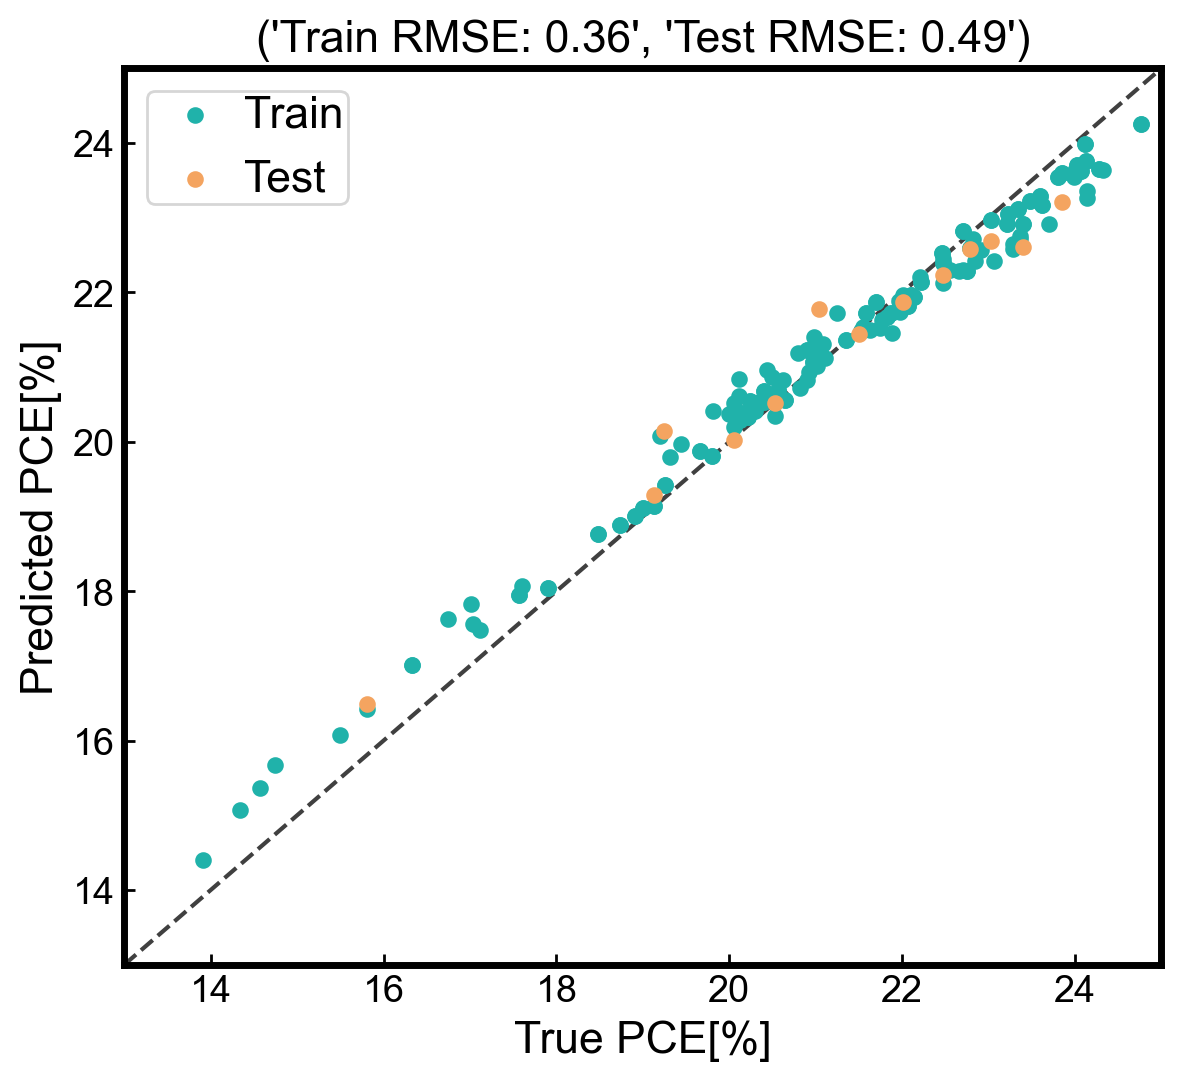

RMSE Train: 0.36
RMSE Test: 0.49
^^^^^^^^^^^^^^^^^^^^
MAE Train: 0.29
MAE Test: 0.38
^^^^^^^^^^^^^^^^^^^^
R2 Train: 0.97
R2 Test: 0.95
^^^^^^^^^^^^^^^^^^^^
Spearman Train: 0.99
Spearman Test: 0.98
^^^^^^^^^^^^^^^^^^^^


['Model_GB_ZD.pkl']

In [16]:
###GB
from sklearn.ensemble import GradientBoostingRegressor

# Initialize an empty DataFrame to store metrics
metrics_df = pd.DataFrame(columns=['RMSE', 'MAE', 'Spearman', 'R2'])

# Store the indices of the training and testing sets for the best model
best_train_idx = None
best_test_idx = None
best_rmse = float('inf')
rmse_scores = []
mae_scores = []
spearman_scores = []
r2_scores = []

# Store the number of molecules in each scaffold_group for the test set in each round
test_group_sizes = []

# Repeat the testing 200 times
num_trials = 200

for _ in tqdm(range(num_trials), desc="Trials"):
    # Split the dataset into training and testing sets
    train_data = pd.DataFrame(columns=['smiles', 'target_PCE', 'scaffold_group'])
    test_data = pd.DataFrame(columns=['smiles', 'target_PCE', 'scaffold_group'])
    
    # Select one sample from each scaffold_group for the test set
    for group_idx in range(len(scaffold_groups)):
        group_df = data[data['scaffold_group'] == group_idx]
        test_df = group_df.sample(n=1)
        train_df = group_df.drop(test_df.index)

        train_data = pd.concat([train_data, train_df], ignore_index=False)
        test_data = pd.concat([test_data, test_df], ignore_index=False)

    # Ensure the total test set size is 13
    total_test_size = 13
    test_size_per_group = total_test_size - len(scaffold_groups)
    remaining_scaffold_groups = [group_idx for group_idx in range(len(scaffold_groups)) if len(data[data['scaffold_group'] == group_idx]) > 3]

    for _ in range(test_size_per_group):
        # Randomly select a scaffold_group
        random_group_idx = random.choice(remaining_scaffold_groups)
        group_df = data[data['scaffold_group'] == random_group_idx]
        num_samples = len(group_df)
        test_size = min(1, num_samples)  # Ensure at least one molecule is selected for the test set
        test_df = group_df.sample(n=test_size)
        train_df = group_df.drop(test_df.index)

        train_data = pd.concat([train_data, train_df], ignore_index=False)
        test_data = pd.concat([test_data, test_df], ignore_index=False)
        
        test_size_per_group -= test_size
        remaining_scaffold_groups.remove(random_group_idx)
        
        # Exit the loop if the required number of test samples has been reached
        if test_size_per_group <= 0:
            break

    # Record the number of molecules from each scaffold_group in the test set for each round
    test_group_sizes.append(test_data.groupby('scaffold_group').size().tolist())

    X_scaler = MinMaxScaler()
    X_scaler.fit(zd)
    zd = X_scaler.transform(zd)

    X_train = zd[train_data.index]
    y_train = np.transpose([train_data['target_PCE'].values])
    X_test = zd[test_data.index]
    y_test = np.transpose([test_data['target_PCE'].values])
    print("Test set size:", len(y_test))

    # Fit to the training set
    gb_regressor = GradientBoostingRegressor(n_estimators=35, max_depth=4)
    gb_regressor.fit(X_train, y_train)

    # Perform predictions on both the training and test sets
    y_train_pred = gb_regressor.predict(X_train)
    y_test_pred = gb_regressor.predict(X_test)

    # Calculate RMSE, MAE, Spearman correlation, and R2 score for the current test
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae = mean_absolute_error(y_test, y_test_pred)
    spearman_corr, _ = spearmanr(y_test.flatten(), y_test_pred.flatten())
    r2 = r2_score(y_test, y_test_pred)
    
    # Store the metrics for each trial
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    spearman_scores.append(spearman_corr)
    r2_scores.append(r2)

    # Record the metrics in the DataFrame
    metrics_df = metrics_df.append({'RMSE': rmse, 'MAE': mae, 'Spearman': spearman_corr, 'R2': r2}, ignore_index=True)

    # If the current model has a better RMSE, update the best model's predictions and true values
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_predictions = y_test_pred
        best_model_true_values = y_test
        best_train_idx = train_data.index.tolist()
        best_test_idx = test_data.index.tolist()
        
# Calculate mean and standard deviation
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)
mean_spearman = np.mean(spearman_scores)
std_spearman = np.std(spearman_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

# Save the mean and standard deviation to a DataFrame
summary_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'Spearman', 'R2'],
    'Mean': [mean_rmse, mean_mae, mean_spearman, mean_r2],
    'Std': [std_rmse, std_mae, std_spearman, std_r2]})

# Save the metrics to a CSV file
metrics_df.to_csv('metrics_GB_ZD.csv', index=False)
summary_df.to_csv('metrics_summary_GB_ZD.csv', index=False)

# Print the number of molecules in each scaffold_group for every test set
print("Test group sizes for each trial:")
for i, sizes in enumerate(test_group_sizes):
    print(f"Iteration {i+1}: {sizes}")
    
# Print the summary of mean and standard deviation
print(summary_df)

# Plot the predicted vs ground truth values for the best model
prediction_vs_ground_truth_fig(y_train, y_train_pred, best_model_true_values, best_model_predictions)

# Save the indices of the best model's training and testing sets to a CSV file
best_model_indices_df = pd.DataFrame({'train_idx': pd.Series(best_train_idx), 'test_idx': pd.Series(best_test_idx)})
best_model_indices_df.to_csv('Indices_GB_ZD.csv', index=False)

# Save the best model
gb_regressor = GradientBoostingRegressor(n_estimators=35, max_depth=4)
gb_regressor.fit(zd[best_train_idx], data['target_PCE'][best_train_idx])
joblib.dump(gb_regressor, 'Model_GB_ZD.pkl')

Trials:   2%|█                                                                         | 3/200 [00:00<00:18, 10.94it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:   2%|█▊                                                                        | 5/200 [00:00<00:17, 11.34it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:   4%|██▌                                                                       | 7/200 [00:00<00:17, 11.29it/s]

测试集数量: 13
测试集数量: 13


Trials:   5%|███▋                                                                     | 10/200 [00:01<00:22,  8.62it/s]

测试集数量: 13
测试集数量: 13


Trials:   6%|████▍                                                                    | 12/200 [00:01<00:25,  7.50it/s]

测试集数量: 13
测试集数量: 13


Trials:   7%|█████                                                                    | 14/200 [00:01<00:26,  7.07it/s]

测试集数量: 13
测试集数量: 13


Trials:   8%|█████▍                                                                   | 15/200 [00:01<00:27,  6.75it/s]

测试集数量: 13
测试集数量: 13


Trials:  10%|██████▉                                                                  | 19/200 [00:02<00:22,  8.10it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  10%|███████▋                                                                 | 21/200 [00:02<00:18,  9.45it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  12%|█████████▏                                                               | 25/200 [00:02<00:16, 10.84it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  14%|█████████▊                                                               | 27/200 [00:02<00:15, 11.27it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  16%|███████████▎                                                             | 31/200 [00:03<00:14, 11.90it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  16%|████████████                                                             | 33/200 [00:03<00:14, 11.90it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  18%|█████████████▌                                                           | 37/200 [00:03<00:13, 12.29it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  20%|██████████████▏                                                          | 39/200 [00:03<00:12, 12.55it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  22%|███████████████▋                                                         | 43/200 [00:04<00:12, 12.32it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  22%|████████████████▍                                                        | 45/200 [00:04<00:14, 10.82it/s]

测试集数量: 13
测试集数量: 13


Trials:  24%|█████████████████▏                                                       | 47/200 [00:04<00:16,  9.37it/s]

测试集数量: 13
测试集数量: 13


Trials:  25%|██████████████████▎                                                      | 50/200 [00:05<00:15,  9.83it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  26%|██████████████████▉                                                      | 52/200 [00:05<00:14, 10.45it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  28%|████████████████████▍                                                    | 56/200 [00:05<00:12, 11.40it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  29%|█████████████████████▏                                                   | 58/200 [00:05<00:12, 11.61it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  30%|█████████████████████▉                                                   | 60/200 [00:05<00:11, 11.67it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  32%|███████████████████████▎                                                 | 64/200 [00:06<00:11, 11.80it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  34%|████████████████████████▊                                                | 68/200 [00:06<00:10, 12.10it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  35%|█████████████████████████▌                                               | 70/200 [00:06<00:10, 12.10it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  37%|███████████████████████████                                              | 74/200 [00:07<00:10, 12.08it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  38%|███████████████████████████▋                                             | 76/200 [00:07<00:10, 12.09it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  40%|█████████████████████████████▏                                           | 80/200 [00:07<00:09, 12.16it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  41%|█████████████████████████████▉                                           | 82/200 [00:07<00:09, 12.29it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  43%|███████████████████████████████▍                                         | 86/200 [00:08<00:09, 12.58it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  44%|████████████████████████████████                                         | 88/200 [00:08<00:09, 12.19it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  46%|█████████████████████████████████▌                                       | 92/200 [00:08<00:08, 12.50it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  47%|██████████████████████████████████▎                                      | 94/200 [00:08<00:08, 12.56it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  49%|███████████████████████████████████▊                                     | 98/200 [00:08<00:08, 12.33it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  50%|████████████████████████████████████                                    | 100/200 [00:09<00:08, 12.19it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  52%|█████████████████████████████████████▍                                  | 104/200 [00:09<00:07, 12.48it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  53%|██████████████████████████████████████▏                                 | 106/200 [00:09<00:07, 12.33it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  55%|███████████████████████████████████████▌                                | 110/200 [00:09<00:07, 12.20it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  56%|████████████████████████████████████████▎                               | 112/200 [00:10<00:07, 12.36it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  58%|█████████████████████████████████████████▊                              | 116/200 [00:10<00:06, 12.66it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  59%|██████████████████████████████████████████▍                             | 118/200 [00:10<00:06, 12.44it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  61%|███████████████████████████████████████████▉                            | 122/200 [00:10<00:06, 12.48it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  62%|████████████████████████████████████████████▋                           | 124/200 [00:11<00:06, 12.40it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  64%|██████████████████████████████████████████████                          | 128/200 [00:11<00:05, 12.22it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  65%|██████████████████████████████████████████████▊                         | 130/200 [00:11<00:05, 12.15it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  67%|████████████████████████████████████████████████▏                       | 134/200 [00:11<00:05, 12.32it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  68%|████████████████████████████████████████████████▉                       | 136/200 [00:12<00:05, 12.61it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  70%|██████████████████████████████████████████████████▍                     | 140/200 [00:12<00:04, 12.35it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  71%|███████████████████████████████████████████████████                     | 142/200 [00:12<00:04, 12.24it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  73%|████████████████████████████████████████████████████▌                   | 146/200 [00:12<00:04, 12.28it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  74%|█████████████████████████████████████████████████████▎                  | 148/200 [00:13<00:04, 12.35it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  76%|██████████████████████████████████████████████████████▋                 | 152/200 [00:13<00:03, 12.22it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  77%|███████████████████████████████████████████████████████▍                | 154/200 [00:13<00:03, 12.17it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  79%|████████████████████████████████████████████████████████▉               | 158/200 [00:13<00:03, 12.43it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  80%|█████████████████████████████████████████████████████████▌              | 160/200 [00:14<00:03, 12.19it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  82%|███████████████████████████████████████████████████████████             | 164/200 [00:14<00:02, 12.59it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  83%|███████████████████████████████████████████████████████████▊            | 166/200 [00:14<00:02, 12.38it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  85%|█████████████████████████████████████████████████████████████▏          | 170/200 [00:14<00:02, 12.37it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  86%|█████████████████████████████████████████████████████████████▉          | 172/200 [00:15<00:02, 12.44it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  88%|███████████████████████████████████████████████████████████████▎        | 176/200 [00:15<00:01, 12.18it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  89%|████████████████████████████████████████████████████████████████        | 178/200 [00:15<00:01, 12.20it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  90%|████████████████████████████████████████████████████████████████▊       | 180/200 [00:15<00:01, 11.98it/s]

测试集数量: 13
测试集数量: 13
测试集数量:

Trials:  92%|██████████████████████████████████████████████████████████████████▏     | 184/200 [00:16<00:01, 11.44it/s]

 13
测试集数量: 13
测试集数量: 13


Trials:  93%|██████████████████████████████████████████████████████████████████▉     | 186/200 [00:16<00:01, 11.30it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  95%|████████████████████████████████████████████████████████████████████▍   | 190/200 [00:16<00:00, 12.05it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  96%|█████████████████████████████████████████████████████████████████████   | 192/200 [00:16<00:00, 12.07it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  97%|█████████████████████████████████████████████████████████████████████▊  | 194/200 [00:16<00:00, 11.94it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials:  99%|███████████████████████████████████████████████████████████████████████▎| 198/200 [00:17<00:00, 12.19it/s]

测试集数量: 13
测试集数量: 13
测试集数量: 13


Trials: 100%|████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.51it/s]


测试集数量: 13
Test group sizes for each trial:
Iteration 1: [2, 2, 2, 2, 1, 1, 1, 1, 1]
Iteration 2: [2, 2, 2, 1, 2, 1, 1, 1, 1]
Iteration 3: [2, 2, 1, 1, 2, 1, 2, 1, 1]
Iteration 4: [2, 2, 1, 1, 2, 1, 2, 1, 1]
Iteration 5: [2, 2, 1, 1, 2, 1, 2, 1, 1]
Iteration 6: [1, 2, 2, 2, 2, 1, 1, 1, 1]
Iteration 7: [2, 2, 2, 1, 1, 1, 2, 1, 1]
Iteration 8: [2, 2, 1, 1, 2, 1, 2, 1, 1]
Iteration 9: [1, 2, 2, 2, 1, 1, 2, 1, 1]
Iteration 10: [2, 2, 2, 1, 1, 1, 2, 1, 1]
Iteration 11: [2, 1, 2, 1, 2, 1, 2, 1, 1]
Iteration 12: [1, 2, 2, 2, 1, 1, 2, 1, 1]
Iteration 13: [2, 2, 2, 2, 1, 1, 1, 1, 1]
Iteration 14: [2, 1, 2, 2, 1, 1, 2, 1, 1]
Iteration 15: [2, 1, 1, 2, 2, 1, 2, 1, 1]
Iteration 16: [2, 2, 2, 2, 1, 1, 1, 1, 1]
Iteration 17: [1, 2, 2, 2, 2, 1, 1, 1, 1]
Iteration 18: [2, 1, 1, 2, 2, 1, 2, 1, 1]
Iteration 19: [2, 1, 2, 2, 2, 1, 1, 1, 1]
Iteration 20: [2, 1, 2, 2, 1, 1, 2, 1, 1]
Iteration 21: [2, 2, 2, 1, 1, 1, 2, 1, 1]
Iteration 22: [2, 1, 2, 2, 1, 1, 2, 1, 1]
Iteration 23: [1, 2, 2, 1, 2, 1, 2, 1, 1]


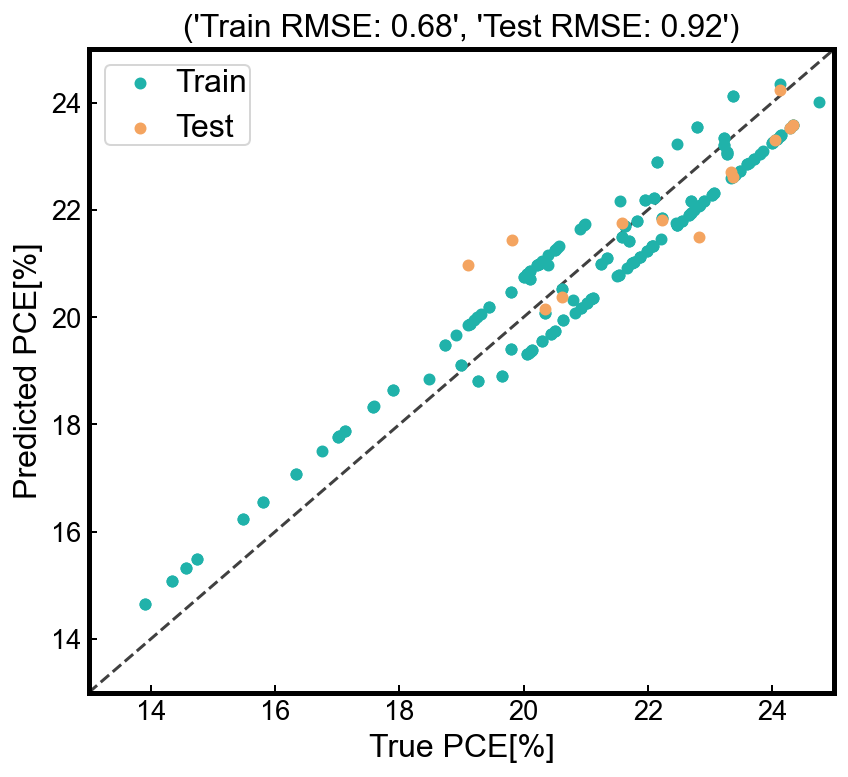

RMSE Train: 0.68
RMSE Test: 0.92
^^^^^^^^^^^^^^^^^^^^
MAE Train: 0.64
MAE Test: 0.74
^^^^^^^^^^^^^^^^^^^^
R2 Train: 0.92
R2 Test: 0.73
^^^^^^^^^^^^^^^^^^^^
Spearman Train: 0.95
Spearman Test: 0.92
^^^^^^^^^^^^^^^^^^^^


['Model_SVR_ZD.pkl']

In [7]:
###SVR
from sklearn.svm import SVR

# Initialize an empty DataFrame to store metrics
metrics_df = pd.DataFrame(columns=['RMSE', 'MAE', 'Spearman', 'R2'])

# Store the indices of the training and testing sets for the best model
best_train_idx = None
best_test_idx = None
best_rmse = float('inf')
rmse_scores = []
mae_scores = []
spearman_scores = []
r2_scores = []

# Store the number of molecules from each scaffold_group in the test set for each trial
test_group_sizes = []

# Repeat the testing 200 times
num_trials = 200

for _ in tqdm(range(num_trials), desc="Trials"):
    # Split the dataset into training and testing sets
    train_data = pd.DataFrame(columns=['smiles', 'target_PCE', 'scaffold_group'])
    test_data = pd.DataFrame(columns=['smiles', 'target_PCE', 'scaffold_group'])
    
    # Select one sample from each scaffold_group for the test set
    for group_idx in range(len(scaffold_groups)):
        group_df = data[data['scaffold_group'] == group_idx]
        test_df = group_df.sample(n=1)
        train_df = group_df.drop(test_df.index)

        train_data = pd.concat([train_data, train_df], ignore_index=False)
        test_data = pd.concat([test_data, test_df], ignore_index=False)

    # Ensure the total test set size is 13
    total_test_size = 13
    test_size_per_group = total_test_size - len(scaffold_groups)
    remaining_scaffold_groups = [group_idx for group_idx in range(len(scaffold_groups)) if len(data[data['scaffold_group'] == group_idx]) > 3]

    for _ in range(test_size_per_group):
        # Randomly select a scaffold_group
        random_group_idx = random.choice(remaining_scaffold_groups)
        group_df = data[data['scaffold_group'] == random_group_idx]
        num_samples = len(group_df)
        test_size = min(1, num_samples)  # Ensure at least one molecule is selected for the test set
        test_df = group_df.sample(n=test_size)
        train_df = group_df.drop(test_df.index)

        train_data = pd.concat([train_data, train_df], ignore_index=False)
        test_data = pd.concat([test_data, test_df], ignore_index=False)
        
        test_size_per_group -= test_size
        remaining_scaffold_groups.remove(random_group_idx)
        
        # Exit the loop if the required number of test samples has been reached
        if test_size_per_group <= 0:
            break

    # Record the number of molecules from each scaffold_group in the test set for each trial
    test_group_sizes.append(test_data.groupby('scaffold_group').size().tolist())

    X_scaler = MinMaxScaler()
    X_scaler.fit(zd)
    zd = X_scaler.transform(zd)

    X_train = zd[train_data.index]
    y_train = np.transpose([train_data['target_PCE'].values])
    X_test = zd[test_data.index]
    y_test = np.transpose([test_data['target_PCE'].values])
    print("Test set size:", len(y_test))

    # Fit to the training set
    sv_regressor = SVR(C=500, epsilon=0.75)
    sv_regressor.fit(X_train, y_train)

    # Perform predictions on both training and test sets
    y_train_pred = sv_regressor.predict(X_train)
    y_test_pred = sv_regressor.predict(X_test)

    # Calculate RMSE, MAE, Spearman correlation, and R2 score for the current test
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae = mean_absolute_error(y_test, y_test_pred)
    spearman_corr, _ = spearmanr(y_test.flatten(), y_test_pred.flatten())
    r2 = r2_score(y_test, y_test_pred)
    
    # Store the metrics for each trial
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    spearman_scores.append(spearman_corr)
    r2_scores.append(r2)

    # Record the metrics in the DataFrame
    metrics_df = metrics_df.append({'RMSE': rmse, 'MAE': mae, 'Spearman': spearman_corr, 'R2': r2}, ignore_index=True)

    # If the current model has a better RMSE, update the best model's predictions and true values
    if rmse < best_rmse:
        best_rmse = rmse
        best_model_predictions = y_test_pred
        best_model_true_values = y_test
        best_train_idx = train_data.index.tolist()
        best_test_idx = test_data.index.tolist()
        
# Calculate mean and standard deviation
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)
mean_spearman = np.mean(spearman_scores)
std_spearman = np.std(spearman_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

# Save the mean and standard deviation to a DataFrame
summary_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'Spearman', 'R2'],
    'Mean': [mean_rmse, mean_mae, mean_spearman, mean_r2],
    'Std': [std_rmse, std_mae, std_spearman, std_r2]})

# Save the metrics to a CSV file
metrics_df.to_csv('metrics_SVR_ZD.csv', index=False)
summary_df.to_csv('metrics_summary_SVR_ZD.csv', index=False)

# Print the number of molecules from each scaffold_group in every test set
print("Test group sizes for each trial:")
for i, sizes in enumerate(test_group_sizes):
    print(f"Iteration {i+1}: {sizes}")
    
# Print the summary of mean and standard deviation
print(summary_df)

# Plot the predicted vs ground truth values for the best model
prediction_vs_ground_truth_fig(y_train, y_train_pred, best_model_true_values, best_model_predictions)

# Save the indices of the best model's training and testing sets to a CSV file
best_model_indices_df = pd.DataFrame({'train_idx': pd.Series(best_train_idx), 'test_idx': pd.Series(best_test_idx)})
best_model_indices_df.to_csv('Indices_SVR_ZD.csv', index=False)

# Save the best model
sv_regressor = SVR(C=500, epsilon=0.5)
sv_regressor.fit(zd[best_train_idx], data['target_PCE'][best_train_idx])
joblib.dump(sv_regressor, 'Model_SVR_ZD.pkl')